In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  

In [2]:
from IPython.core.display import Image, display

# Construcción de características sintéticas

### Aprendizaje Automático Intermedio e Ingeniería de Características

#### Febrero 2021

**Emilio Parrado Hernández, Vanessa Gómez Verdejo, Pablo Martínez Olmos**

Departamento de Teoría de la Señal y Comunicaciones

**Universidad Carlos III de Madrid**

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

## Contenidos que se van a tratar a lo largo de la sesión

- *Feature templates*
    - Aplicación a características con fechas y horas
    - Aplicación a características con información geográfica
    
- Construcción de características sintéticas empleando aprendizaje automático:
    - mediante *ensembles*
    - mediante *kernels*
    
- Introducción a la creación automática de características sintéticas con *Featuretools*

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

# 1 Introducción a la construcción de características sintéticas

## Transformaciones de variables en características

En la primera sesión del curso presentamos transformaciones más o menos sencillas que podemos aplicar a las variables de entrada para transformarlas en características con las que poder alimentar a los algoritmos de entrenamiento de modelos de aprendizaje automático. A modo de revisión:

- Variables numéricas:
    - Transformaciones logarítmicas (`apply/np.log10)`)
    - Discretización o cuantificación de variables continuas (`DataFrame.quantile()`, `np.digitize`)
    - Escalados (`StandardScaler()`, `MinMaxScaler()`, `MaxAbsScaler()`)
    - Transformaciones de histograma (`quantile_transform()`, Box-Cox)
    - Combinaciones de características (`PolynomialFeatures()`)
- Variables categóricas:
    - *One-Hot Encoding* y derivados
    - *Hashing* de características (`FeatureHasher()`)
    - Conteos de bin

Mediante estas funcionalidades básicas podemos:
- Adaptar variables categóricas para manejar modelos numéricos
- Adaptar rangos de variables para reducir las limitaciones matemáticas de estos modelos
- Ayudar al modelo a capturar patrones que dependen de no-linealidades y de relaciones entre grupos de variables. 




<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

En este notebook vamos a extender estas funcionalidades con diferentes técnicas que **transformen** las características que se extraen directamente de las variables que recibimos en la definición del problema en juegos de características **orientados a mejorar la precisión del modelo** de aprendizaje automático de la etapa posterior.

El empleo de características sintéticas puede **oscurecer de algún modo la interpretabilidad** detallada de los modelos, pero sí que va a contribuir (en combinación con métodos de selección de características) a ayudarnos a identificar **qué variables o combinaciones de variables son relevantes** para la definición de los patrones subyacentes al conjunto de datos y que necesitamos capturar para resolver la tarea de aprendizaje.

Estas transformaciones están orientadas fundamentalmente a conseguir **representaciones alternativas** de información que **ya estaba contenida en el conjunto de entrenamiento** pero que al modelo de aprendizaje automático le cuesta recuperar por dos causas fundamentales:
- No tiene suficiente capacidad expresiva para capturar el patrón que define el mapeo entre observaciones y targets
- Tiene capacidad expresiva suficiente pero el conjunto de entrenamiento es corto en datos, no tiene suficientes ejemplos para ajustar todos los parámetros del modelo.

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />


### Ejemplos

#### Ejemplo 1

Ajustar un modelo lineal a los datos  de la izquierda de la figura. El modelo verdadero es razonablemente suave, pero el modelo lineal no es suficientemente expresivo para capturarlo.



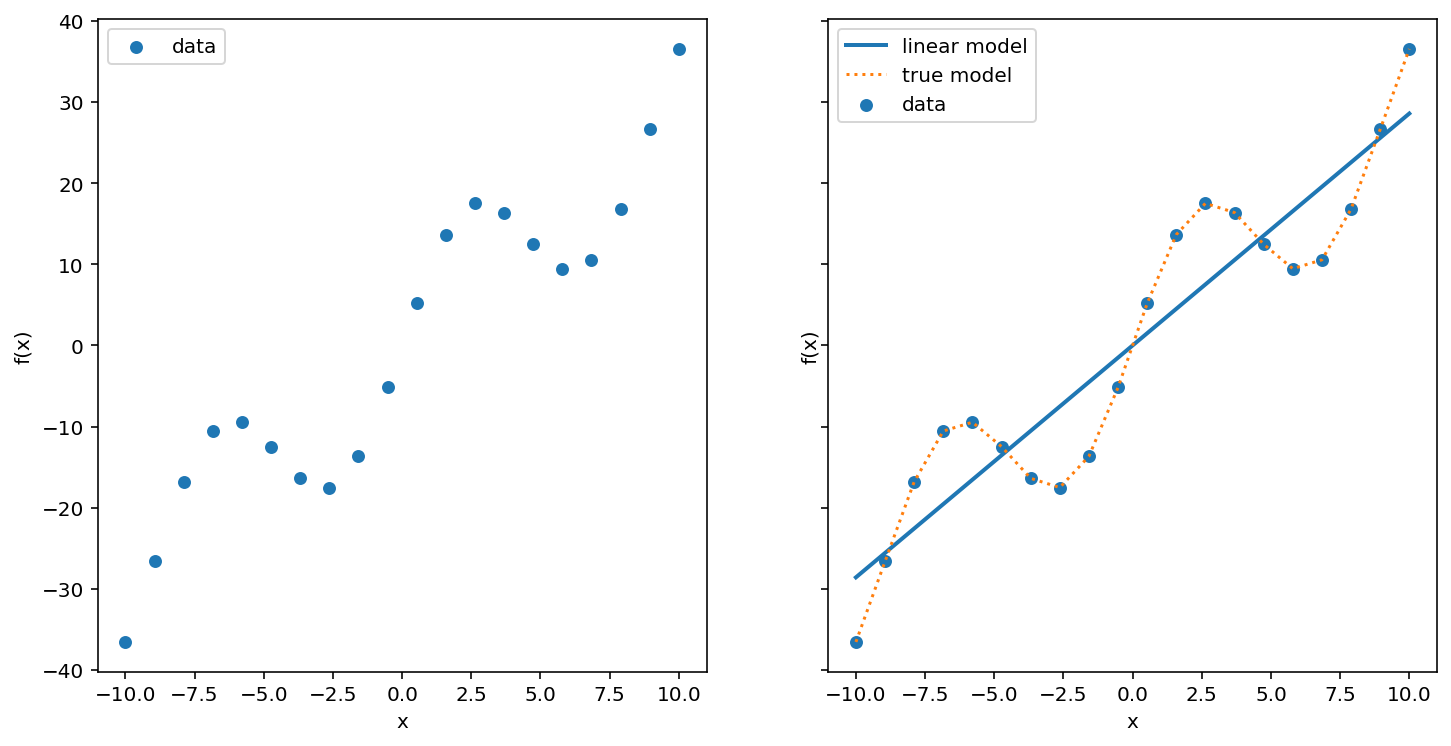

In [3]:
import numpy as np
import matplotlib.pyplot as plt
t = np.linspace(-10,10,20)
x = 10*np.sin(.7*t)+3*t
ff,aa = plt.subplots(1,2,sharex=True,sharey=True, figsize=(12,6))
aa[0].scatter(t,x,s=30,label='data')
aa[0].set_xlabel('x')
aa[0].set_ylabel('f(x)')
aa[0].legend()

from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(t.reshape(-1,1),x)
y_lr = lr.predict(t.reshape(-1,1))

aa[1].scatter(t,x,s=30,label='data')
aa[1].plot(t,y_lr,linewidth=2,label='linear model')
aa[1].plot(t,x,linestyle=':',label='true model')

aa[1].set_xlabel('x')
aa[1].set_ylabel('f(x)')
_=aa[1].legend()

#### Ejemplo 2

Tenemos un problema de clasificación de imágenes con datos de caras digitalizadas. Nuestra tarea es predecir la etiqueta correcta de de la tercera imagen, sabiendo únicamente que la etiqueta de la primera imagen es $+1$ y la etiqueta de la segunda es $-1$

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTERMEDIO/caras1.png' width=400 />


Necesitamos un número **suficiente de observaciones** para saber si lo que **el modelo debe capturar es que** la tercera imagen es otra imagen del sujeto de la segunda imagen (predecir etiqueta $-1$) u otra imagen con gafas (predecir etiqueta $+1$)

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

## Ejemplos sobre la idoneidad de las características

En general, al decidir emplear un modelo de aprendizaje automático, **asumimos que la información que necesitamos capturar** para la construcción del modelo está contenida en los datos, y que es posible **deconstruir** las transformaciones inherentes a los datos originales hasta recuperar el patrón que estamos buscando. Usando un símil de cocina, cuando probamos algo intentamos imaginar/evocar los ingredientes originales y las transformaciones realizadas sobre éstos hasta llegar al resultado. Y asumimos que si aparece un sabor en el resultado final, es que ese ingrediente estaba en el principio del proceso: si sabe a frutos rojos, es que había frutos rojos... o las *features* que hacen que los frutos rojos sepan a frutos rojos...

Vamos a ilustrar los diferentes grados de dificultad para **deconstruir** el modelo utilizando aprendizaje automático en unas tareas de regresión sencillas. La siguiente tabla describe 8 tareas de regresión que se construyen mezclando hasta 4 variables de entrada $\{x_1, x_2, x_3, x_4\}$ que toman valores continuos entre $0$ y $10$.

| Descripción    | Expresión |  Índice    |
| :---        |    :------------:   |          ---: |
| Diferencia      | $x_1 - x_2$       | f1   |
| Logaritmo   | $\log(x_1)$        | f2      |
| Polinomio   | $2+4x_1x_2+5 x_1^2x_2^2$        | f3      |
| Potencia   | $x_1^2$        | f4      |
| Cociente   | $\frac{x_1}{x_2} $       | f5      |
| Cociente de Diferencias   | $\frac{x_1 - x_2}{x_3 - x_4}$        | f6   |
| Cociente de Polinomios   | $$\frac{1}{2+4x_1x_2+5 x_1^2x_2^2}$$        | f7     |
| Raíz cuadrada   | $\sqrt{x_1}$        | f8   |




In [4]:
# Construcción de las funciones. **Sin ruido**

def f1(x):
    return x[:,:2], x[:,0] - x[:,1]
def f2(x):
    return x[:,0].reshape(-1,1), np.log(x[:,0])
def f3(x):
    return x[:,:2], 2 + 4*x[:,0]*x[:,1] + 5*(x[:,0]*x[:,1])**2
def f4(x):
    return x[:,0].reshape(-1,1), x[:,0]**2
def f5(x):
    return x[:,:2], x[:,0] / x[:,1]
def f6(x):
    return x, (x[:,0] - x[:,1]) / (x[:,2] - x[:,3])

def f7(x):
    return x[:,:2], 1/(5*(x[:,0]*x[:,1])**2 + 2 + 4*x[:,0]*x[:,1])
def f8(x):
    return x[:,0].reshape(-1,1), x[:,0]**.5

# Generar conjuntos de entrenamiento y test independientes
xr = np.random.rand(100,4)*10
xt = np.random.rand(100,4)*10

Vamos a emplear un modelo de regresión lineal sencillo [LinearRegression()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) y una alternativa no lineal más sofisticada que es [*Kernel Ridge Regression*](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html). Lo veremos en un poco más de detalle luego, pero adelantamos que Kernel Ridge Regression aprende una combinación lineal de funciones kernel centradas en los datos de entrenamiento (parecido a la SVM).

In [5]:

# preparar el modelo Kernel Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

v_gamma = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
params = {'gamma':v_gamma}
grid_kr = GridSearchCV(KernelRidge(alpha=0.001,
                                  kernel='rbf'), 
                      param_grid=params)

# preparar el modelo lineal sencillo
lr = LinearRegression()


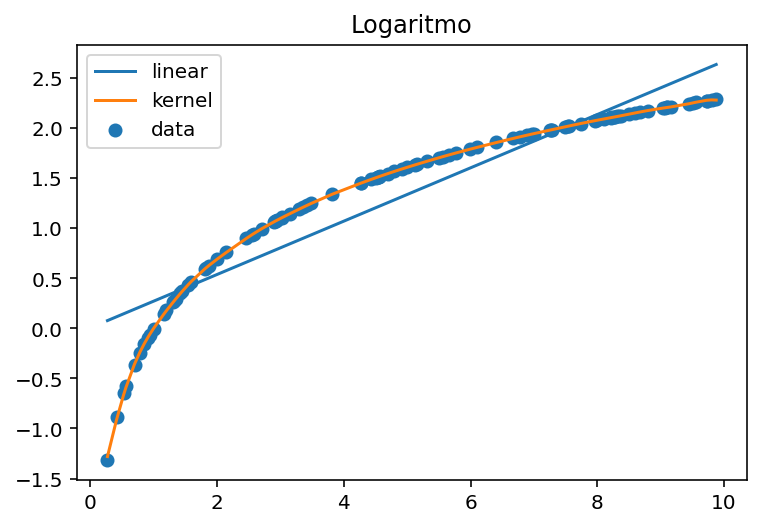

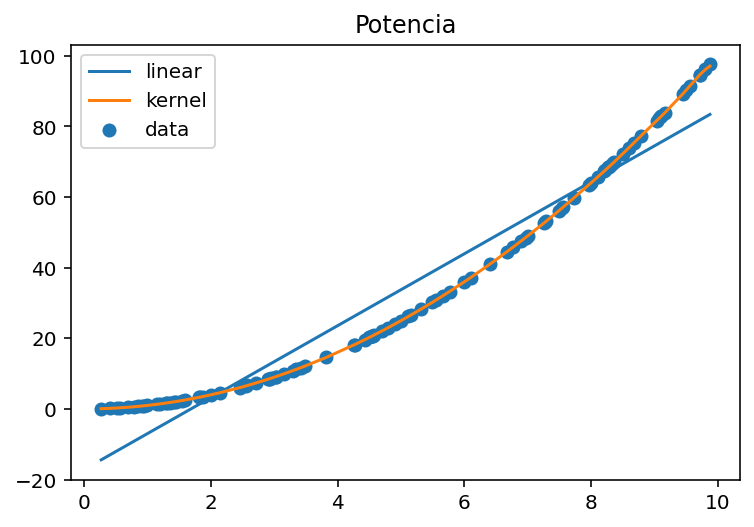

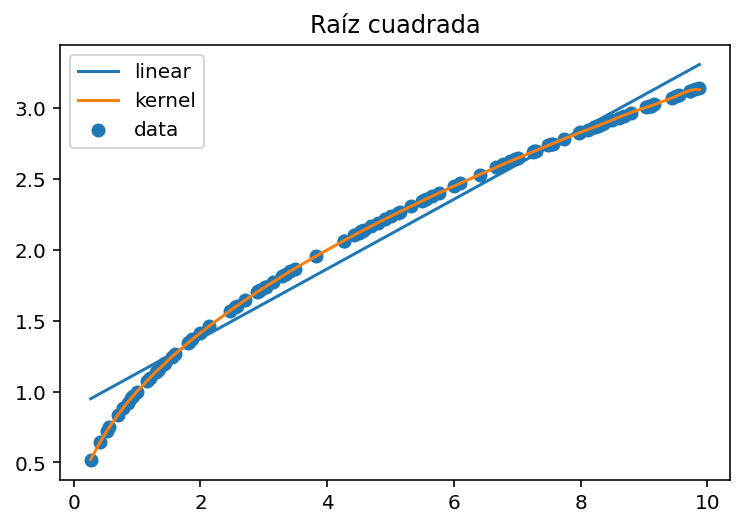

In [6]:
#Aplicar machine learning

v_f = [f1, f2, f3, f4, f5, f6, f7, f8]
v_f_names = ['Diferencia',
            'Logaritmo',
            'Polinomio',
            'Potencia',
            'Cociente',
            'Cociente de Diferencias',
            'Cociente de Polinomios',
            'Raíz cuadrada']
av_error = np.empty(len(v_f))
std_error = np.empty(len(v_f))
min_error = np.empty(len(v_f))
max_error = np.empty(len(v_f))
l_av_error = np.empty(len(v_f))
l_std_error = np.empty(len(v_f))
l_min_error = np.empty(len(v_f))
l_max_error = np.empty(len(v_f))
for iff,ff in enumerate(v_f):
    x1, y1 = ff(xr)
    x2, y2 = ff(xt)
    grid_kr.fit(x1, y1)
    er = np.absolute(y2 - grid_kr.predict(x2))
    av_error[iff] = np.mean(er)
    std_error[iff] = np.std(er)
    min_error[iff] =np.min(er)
    max_error[iff] =np.max(er)
    lr.fit(x1, y1)
    ler = np.absolute(y2 - lr.predict(x2))
    l_av_error[iff] = np.mean(ler)
    l_std_error[iff] = np.std(ler)
    l_min_error[iff] =np.min(ler)
    l_max_error[iff] =np.max(ler)
    # en los problemas 1D podemos representar gráficamente
    if x1.shape[1]==1:
        xs = np.sort(np.squeeze(x1))
        plt.figure()
        plt.scatter(x1,y1,label='data')
        plt.plot(xs, lr.predict(xs.reshape(-1,1)), label='linear')
        plt.plot(xs, grid_kr.predict(xs.reshape(-1,1)), label='kernel')
        plt.legend()
        plt.title(v_f_names[iff])

La siguiente tabla muestra lo bien o mal que cada uno de los dos modelos has sido capaz de capturar los patrones incluidos en los datos.

In [7]:
import pandas as pd    
resultados = pd.DataFrame()
resultados['función'] = v_f_names
resultados['Linear Mean Error'] = l_av_error
resultados['Linear StdDev Error'] = l_std_error
resultados['K Ridge Mean Error'] = av_error
resultados['K Ridge StdDev Error'] = std_error

for cc in resultados.columns[1:]:
    resultados[cc] = resultados[cc].apply(lambda x:np.round(x,2))

display(resultados)

,función,Linear Mean Error,Linear StdDev Error,K Ridge Mean Error,K Ridge StdDev Error
0,Diferencia,0.00,0.00,0.01,0.02
1,Logaritmo,0.29,0.30,0.01,0.04
2,Polinomio,2849.17,2604.31,90.97,80.30
3,Potencia,6.46,3.92,0.06,0.26
4,Cociente,5.15,14.33,3.58,15.35
5,Cociente de Diferencias,2.87,4.98,2.69,4.85
6,Cociente de Polinomios,0.02,0.04,0.01,0.05
7,Raíz cuadrada,0.11,0.09,0.00,0.01


# 2. Plantillas de características (*feature templates*)

Esta sección **extiende las transformaciones de características** que vimos en la primera clase mediante la definición de automatizaciones que nos permitan generar características de modo masivo y sencillo a partir de los datos de entrada. 

El primer paso para abordar la resolución de un problema mediante aprendizaje automático es la **elección del modelo**. Aquí elegiremos si queremos un modelo lineal, polinómico, SVM, red neuronal, etc. Cuando instanciamos un modelo, por ejemplo 
~~~
modelo = sklearn.svm.SVC(kernel='rbf', C=10, gamma=1)
~~~

estamos creando un objeto software con un potencial conjunto de parámetros libres cuyo valor se optimizará durante el entrenamiento del modelo.

Una vez elegido el modelo, es necesario aplicar **ingeniería de características** para obtener las características con las que se va a alimentar el modelo. Elegir las características nos **determina la matriz de datos** $X$ donde cada observación es una fila y las columnas vienen dadas por esas características. Cambiar de características implica cambiar las columnas de esta matriz. El modelo sólo va a poder explotar información contenida en la matriz de datos que definen las características calculadas. Por lo tanto, la **elección de las características** que definen el problema  puede entenderse como una **acotación del espacio de modelos**. El objeto `sklearn.svm.SVC` que hemos creado antes puede aprender potencialmente infintas SVMs (los vectores soporte pueden ser cualquier cosa), eso sí todas ellas con *kernels* RBF con `gamma=1` y con coeficientes $0\le \alpha\le 10$. Pero una vez que definimos las características y el conjunto de entrenamiento, acotamos ese conjunto a combinaciones lineales de *kernels* centrados en las observaciones del conjunto de entrenamiento, y estas observaciones están definidas con las características.

Finalmente se invoca el método `fit()` correspondiente para que encuentre el modelo óptimo que se devolverá como solución para resolver el problema de tratamiento de datos. Este paso, que es lo que habitualmente se conoce como **aprendizaje** consiste en fijar los parámetros libres del modelo para acomodar la participación de cada una de las características en la definición del modelo concreto. El método `fit()` **no puede buscar soluciones fuera** del espacio de búsqueda delimitado por el modelo elegido y por las características calculadas.

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTERMEDIO/fe_templates1.png' width=800 />

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

## 2.1 Ejemplo para motivar: clasificador de direcciones de *email*

Vamos a pensar en un modelo que reciba como entrada una cadena de texto y su salida tenga que ser $+1$ si la cadena es una dirección de *email* válida y $-1$ si no es una dirección de *email* válida.

Además, especificamos que el modelo sea **lineal** por su sencillez de manejo y para poder interpretar el impacto de cada característica en la clasificación final.

$$
x=\mbox{'hola@tumail.com'} \rightarrow \boldsymbol \phi(x) \rightarrow f_{\mathbf w}(x) =  \mbox{signo}\left(\mathbf w^\top \boldsymbol \phi(x) \right) \rightarrow \left\{ \begin{array}{ll} +1 & \mbox{si } x \mbox{ es un email válido} \\ -1 & \mbox{en cualquier otro caso} \end{array}\right.
$$

Los pasos que necesitamos completar hasta obtener el modelo son:
1. Extraer características numéricas que **parametricen** (capturen información relevante) de cada dirección de correo 
2. Aprender los parámetros del modelo (vector de pesos y término de sesgo o `intercept_`)
3. Una vez que el modelo esté aprendido podremos hacer **inferencia**, es decir, usarlo para predecir la clase correcta de las observaciones **de test**.

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

### Extractor de características

El paso donde ponemos el foco en este curso es en el diseño de **extractor de características**. Este módulo debe construir $\boldsymbol \phi(x)$ a partir de la cadena de texto $x$. Algunas características que podrían tener interés:

$$
x=\mbox{hola@tumail.com} \rightarrow \boldsymbol \phi(x) = \left [ \begin{array}{ll} \mbox{len}(x)>12  & : 1 \\ \mbox{RatioAlfanumerico}(x) & : 13/15 \\
\mbox{Contiene@} & : 1 \\ \mbox{TerminaEn_com} & : 1 \\ \mbox{TerminaEn_org} & : 0 \end{array}\right]
$$
<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

### Características *ad hoc*

En el ejemplo anterior todos estábamos de acuerdo en que esas 5 características podían ser una buena representación para resolver el problema con un clasificador lineal. 

En este sentido esperaríamos que el peso de la característica $\mbox{len}(x)>12$ fuese negativo (las direcciones de correo no suelen tener tantos caracteres, los pesos de $\mbox{Contiene@}$, $\mbox{TerminaEn_com}$ y $\mbox{TerminaEn_org}$ fuesen positivos. Y en general obtener una tasa de aciertos aceptables con ese clasificador lineal.

Sin embargo, estas características se han definido de un modo **muy ad hoc** para el problema, usando información de contexto (nuestra experiencia de años intercambiando correos electrónicos). Este procedimiento sería difícil de automatizar y exportar a dominios en los que el *data scientist* no tenga tanto conocimiento del problema a la hora de encontrar características que tengan sentido para el modelo.



<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

## 2.2 Plantillas de características (*feature templates*)

Una **plantilla de características** agrupa características que se obtienen de un modo similar. En el ejemplo que estamos viendo, las características  $\mbox{TerminaEn_com}$ y $\mbox{TerminaEn_org}$ se calculan del mismo modo: mirando a los 3 últimos caracteres de la cadena de texto de entrada.

Una **plantilla de características** define **tipos de patrones a buscar** no patrones concretos:

$$
x=\mbox{hola@tumail.com} \rightarrow  \left [ \begin{array}{ll} \mbox{TerminaEn_aaa} & : 0 \\  \mbox{TerminaEn_aab} & : 0 \\ \cdots & \\ \mbox{TerminaEn_com} & : 1 \\ \cdots & \\ \mbox{TerminaEn_org} & : 0 \\ \cdots & \\ \mbox{TerminaEn_zzz} & : 0\end{array}\right]
$$

No necesitamos saber qué patrones específicos serán útiles (esto se lo dejamos al algoritmo de aprendizaje), sólo que **existen ciertos patrones** que merece la pena explorar.

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

### Ejemplos de plantillas de características

Entrada:
$$
x=\mbox{hola@tumail.com}
$$

| Plantilla    | Ejemplo |  valor    |
| :---        |    :------------   |          ---: |
| Los últimos tres caracteres son *---*      | Los últimos tres caracteres son *com*      | 1   |
| Longitud de la cadena mayor que ---      | Longitud de la cadena mayor que 12      | 1   |
| Fracción de caracteres alfanuméricos     | Fracción de caracteres alfanuméricos       | 13/15   |

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

### Dispersión de los pesos del modelo lineal

El empleo de plantillas de características trae como consecuencia el aumento del número de estas características hasta órdenes de magnitud considerables. Por ejemplo la plantilla sobre los 3 últimos caracteres tiene variaciones (se pueden repetir) de 26 elementos tomados de 3 en 3: $26^3=17576$.

Estas técnicas deben combinarse con:
- una codificación eficiente de la información, por ejemplo usando **diccionarios** de python
- un algoritmo de entrenamiento que incluya la **selección de características** (como los métodos de *embedded feature selection* que vimos en la sesión anterior), o bien un *pipeline* que combine el aprendizaje del modelo con la selección de características.

## 2.3 DictVectorizer, generar *one-hot encoded features* desde diccionarios

La funcionalidad de sklearn [`DictVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) precisamente genera una matriz de características *one-hot encoded* a partir de variables de entrada que vienen definidas en modo disperso mediante diccionarios. 

El resultado de la aplicación de *feature templates* cuando el número  de características sintéticas generadas es grande va a ser una codificación dispersa en la que cada observación está definida por un diccionario donde las claves son las características que sí están presentes en la observación. En el ejemplo de las direcciones de *email*

| x    | observación   |
| :---        |    :------------:   |
|`"hola@tumail.com" ` |`{"len(x)>12" : True,  "Contiene@" : True, "TerminaEn_com": True }`|
|`"@john_rambo"`| `{"len(x)>12" : False,  "Contiene@" : True, "TerminaEn_mbo": True }`|


La salida de `DictVectorizer` sería la siguiente

| "len(x)>12" |  Contiene@  | ... | TerminaEn_com |  ...    |TerminaEn_mbo | ... |
|    :------------:   | :------------:   | :------------:   | :------------:   | :------------:   | :------------:   |          ---: |
| 1       | 1   | ... | 1 | ... | 0 | ... |
| 1       | 1   | ... | 0 | ... | 1 | ... |


### Ejemplo de uso de DictVectorizer con la base de datos YELP academic

Volvemos a cargar la base de datos [Yelp_academic_dataset](https://www.kaggle.com/yelp-dataset/yelp-dataset) que usamos en el primer notebook y aplicamos los siguientes procesamientos

- codificar en escala logarítmica el conteo de revisiones de cada negocio
- Eliminar todos los negocios que no sean "Restaurants"

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

In [8]:
def get_category(df, category='Restaurants'):
    categories_ = df["categories"].dropna()
    is_member = categories_[categories_.apply(lambda x:category in x.split(", "))]
    return df.loc[is_member.index].copy()


import pandas as pd # organize data in dataframes
import json # read the json file with data
from zipfile import ZipFile 
from io import BytesIO
import urllib.request

url = urllib.request.urlopen("http://www.tsc.uc3m.es/~emipar/BBVA/INTERMEDIO/DATASETS/yelp_academic_dataset_business.json.zip")
contained_file = 'yelp_academic_dataset_business.json'
with ZipFile(BytesIO(url.read())) as my_zip_file:
    data_yelp_file = my_zip_file.open(contained_file)
    data_yelp_df = pd.DataFrame([json.loads(x) for x in data_yelp_file.readlines()])
    

# log de conteo de revisiones    
    
data_yelp_df['log10_review_count'] = data_yelp_df['review_count'].apply(np.log10)
    
# quedarnos solo con restaurantes
    
restaurantes = get_category(data_yelp_df)


Recordamos que la tarea que estamos tratando de resolver es predecir el *rating* de los negocios. Vamos a intentar enriquecer las predicciones con características extraídas del campo `attributes`. Representamos el campo `attributes` de uno de los registros:

In [9]:
restaurantes.iloc[23]['attributes']

{'Caters': 'False',
 'OutdoorSeating': 'False',
 'BusinessAcceptsCreditCards': 'True',
 'BikeParking': 'True',
 'HasTV': 'True',
 'RestaurantsAttire': "u'casual'",
 'RestaurantsDelivery': 'True',
 'RestaurantsReservations': 'False',
 'RestaurantsTakeOut': 'True',
 'Alcohol': "u'none'",
 'GoodForKids': 'True',
 'RestaurantsPriceRange2': '1',
 'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}",
 'Ambience': "{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casual': False}",
 'WiFi': "u'no'",
 'NoiseLevel': "u'quiet'",
 'RestaurantsGoodForGroups': 'True',
 'GoodForMeal': "{'dessert': False, 'latenight': False, 'lunch': True, 'dinner': True, 'brunch': False, 'breakfast': False}"}

Tenemos una estructura de diccionarios de 2 niveles: alguno de los valores del diccionario `attributes` es a su vez un diccionario. El siguiente código *aplana* esta estructura de diccionarios en un diccionario con un único nivel.

Notad que el diccionario *interno* está representado como una cadena de caracteres, es decir, **no es un diccionario de python** sino en código que escribiríamos para definir el diccionario. Esto es particular de esta base de datos, es decir, que (hasta donde yo sé) no hay un estándar para codificar esto.

In [10]:
def flatten_dict(d):
    # d: diccionario donde alguno de los valores puede ser otro diccionario
    # ojo esta funcion solo vale para 1 nivel de anidamiento!!
    
    # Lo primero es devolver un diccionario {'empty_attributes':True} 
    # para todos aquellos restaurantes en los que el campo *attributes* está vacío
    # 
    if d is None:
        result= {'empty_attributes':True}
    else:
        result={} # diccionario aplanado que devolvemos
        for k,v in d.items(): 
            if ":" in v: # detectar que el valor es una cadena de caracteres codificando un diccionario en python
                d1 = eval(v) # construir un diccionario d1 con esa cadena de caracteres
                # Eliminamos los items que tengan value None
                d1 = {clave:valor for clave, valor in d1.items() if valor is not None}
                # las claves en el diccionario "aplanado" se construyen concatenando la clave del diccionario
                # externo (k) con la clave del diccionario interno (k1) mediante un "_"
                
                for k1,v1 in d1.items():
                    result.update({k+"_"+k1:v1})
            else: 
                # el valor no es un diccionario. Detectamos si el valor es en realidad una cadena
                # codificando un booleano (esto es particular de este conjunto de datos) y lo transformamos en 
                # booleano, si aplica. Si no, pues devolvemos el valor en modo transparente
                if (v=='True') or (v=='true'):
                    result.update({k:True})
                elif (v=='False') or (v=='false'):
                    result.update({k:False})
                elif (v=='None') or (v=='none') or (v is None) or (v=="u'None'") or (v=="u'none'"):
                    pass
                else:
                    result.update({k:v})
    return result

In [11]:
restaurantes['flat_attributes'] = restaurantes['attributes'].apply(lambda x:flatten_dict(x))

In [12]:
print(restaurantes.index[23])
restaurantes.iloc[23]['flat_attributes']

89


{'Caters': False,
 'OutdoorSeating': False,
 'BusinessAcceptsCreditCards': True,
 'BikeParking': True,
 'HasTV': True,
 'RestaurantsAttire': "u'casual'",
 'RestaurantsDelivery': True,
 'RestaurantsReservations': False,
 'RestaurantsTakeOut': True,
 'GoodForKids': True,
 'RestaurantsPriceRange2': '1',
 'BusinessParking_garage': False,
 'BusinessParking_street': False,
 'BusinessParking_validated': False,
 'BusinessParking_lot': False,
 'BusinessParking_valet': False,
 'Ambience_touristy': False,
 'Ambience_hipster': False,
 'Ambience_romantic': False,
 'Ambience_divey': False,
 'Ambience_intimate': False,
 'Ambience_trendy': False,
 'Ambience_upscale': False,
 'Ambience_classy': False,
 'Ambience_casual': False,
 'WiFi': "u'no'",
 'NoiseLevel': "u'quiet'",
 'RestaurantsGoodForGroups': True,
 'GoodForMeal_dessert': False,
 'GoodForMeal_latenight': False,
 'GoodForMeal_lunch': True,
 'GoodForMeal_dinner': True,
 'GoodForMeal_brunch': False,
 'GoodForMeal_breakfast': False}

Ahora que el campo `attributes` está aplanado podemos aplicar `DictVectorizer` para codificar la información contenida en este campo. 

En este apartado notad que, para simplificar el análisis, estoy **haciendo trampas** porque voy a aprender el transformador con todos los datos, es decir, usando el test también. 

In [13]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
v.fit(restaurantes['flat_attributes'].values.tolist())
atributos = v.transform(restaurantes['flat_attributes'].values.tolist())

In [14]:
aa=pd.Series(atributos[0,:], index=v.feature_names_)
for ii in aa.index:
    print("{0}: {1}".format(ii, aa[ii]))

AcceptsInsurance: 0.0
AgesAllowed=u'18plus': 0.0
AgesAllowed=u'19plus': 0.0
AgesAllowed=u'21plus': 0.0
AgesAllowed=u'allages': 0.0
Alcohol='beer_and_wine': 0.0
Alcohol='full_bar': 0.0
Alcohol='none': 1.0
Alcohol=u'beer_and_wine': 0.0
Alcohol=u'full_bar': 0.0
Ambience={}: 0.0
Ambience_casual: 0.0
Ambience_classy: 0.0
Ambience_divey: 0.0
Ambience_hipster: 0.0
Ambience_intimate: 0.0
Ambience_romantic: 0.0
Ambience_touristy: 0.0
Ambience_trendy: 0.0
Ambience_upscale: 0.0
BYOB: 0.0
BYOBCorkage='no': 0.0
BYOBCorkage='yes_corkage': 0.0
BYOBCorkage='yes_free': 0.0
BYOBCorkage=u'no': 0.0
BYOBCorkage=u'yes_corkage': 0.0
BYOBCorkage=u'yes_free': 0.0
BestNights_friday: 0.0
BestNights_monday: 0.0
BestNights_saturday: 0.0
BestNights_sunday: 0.0
BestNights_thursday: 0.0
BestNights_tuesday: 0.0
BestNights_wednesday: 0.0
BikeParking: 0.0
BusinessAcceptsBitcoin: 0.0
BusinessAcceptsCreditCards: 1.0
BusinessParking={}: 0.0
BusinessParking_garage: 0.0
BusinessParking_lot: 0.0
BusinessParking_street: 0.0
Bu

Vemos que en algunos casos sería conveniente realizar un preprocesamiento que unificase claves como `Alcohol='beer_and_wine'` y `Alcohol=u'beer_and_wine'` o `Alcohol='none'`, `Alcohol=None` y `Alcohol=u'none'`, pero lo dejamos como ejercicio...

#### División entre entrenamiento y test

Para evaluar la capacidad de generalización de los modelos que construyamos podemos dividir la base de datos en dos particiones, entrenamiento y test, al 50% cada una y aplicamos la transformación del `DictVectorizer` a las dos particiones.

In [15]:
from sklearn.model_selection import train_test_split

restaurantes_train, restaurantes_test = train_test_split(restaurantes, 
                                                         test_size=0.5, 
                                                         random_state=42)
 



In [16]:
attr_train = v.transform(restaurantes_train['flat_attributes'].values)
attr_test = v.transform(restaurantes_test['flat_attributes'].values)


Aprendemos un modelo lineal con los logaritmos de los conteos de revisiones

In [17]:
import numpy as np # to get access to math functionalities
from sklearn.linear_model import Ridge
# Training set observations
X_train = restaurantes_train['log10_review_count'].values.reshape(-1,1) # column vector, 1 feature and many rows
# Training set targets
Y_train = restaurantes_train['stars'].values
# Test set observations
X_test = restaurantes_test['log10_review_count'].values.reshape(-1,1)
# Test set targets
Y_test = restaurantes_test['stars'].values

In [18]:
linear_model = Ridge(alpha=0.001).fit(X_train, Y_train)
print("Score with the training data R^2={0:.4f}".format(linear_model.score(X_train, Y_train)))
print("Score with the test data R^2={0:.4f}".format(linear_model.score(X_test, Y_test)))


Score with the training data R^2=0.0392
Score with the test data R^2=0.0374


Ahora enriquecemos el modelo con la salida de `DictVectorizer`

In [19]:
X_train = np.hstack((X_train, attr_train))
X_test = np.hstack((X_test, attr_test))

In [20]:
linear_model_e = Ridge(alpha=0.001).fit(X_train, Y_train)
print("Score with the training data R^2={0:.4f}".format(linear_model_e.score(X_train, Y_train)))
print("Score with the test data R^2={0:.4f}".format(linear_model_e.score(X_test, Y_test)))


Score with the training data R^2=0.1564
Score with the test data R^2=0.1523


Significativa mejora! Si imprimimos los pesos podemos discutir el impacto de alguna de las nuevas variables en la predicción

In [21]:
print("w0 = {0:.4f}".format(linear_model.intercept_))
nombre_feature = ['log10_review_count']
nombre_feature += v.get_feature_names()
pesos = linear_model.coef_
orden = np.argsort(np.absolute(pesos))[::-1]
for ii in orden:
    print("peso {0} = {1:.4f}".format(nombre_feature[ii], pesos[ii]))
 

w0 = 3.0697
peso log10_review_count = 0.2618


In [22]:
print("w0 = {0:.4f}".format(linear_model_e.intercept_))
nombre_feature = ['log10_review_count']
nombre_feature += v.get_feature_names()
pesos = linear_model_e.coef_
orden = np.argsort(np.absolute(pesos))[::-1]
for ii in orden:
    print("peso {0} = {1:.4f}".format(nombre_feature[ii], pesos[ii]))
 

w0 = 3.3730
peso BusinessParking={} = 1.2227
peso Ambience={} = -0.9607
peso HairSpecializesIn_perms = -0.8037
peso GoodForMeal={} = 0.7397
peso DriveThru = -0.6669
peso AgesAllowed=u'allages' = -0.5740
peso NoiseLevel='very_loud' = -0.5705
peso AgesAllowed=u'19plus' = 0.4570
peso NoiseLevel=u'very_loud' = -0.4196
peso DietaryRestrictions_vegetarian = -0.3839
peso AgesAllowed=u'21plus' = -0.3749
peso RestaurantsAttire=u'formal' = -0.3730
peso Open24Hours = -0.3372
peso NoiseLevel='loud' = -0.3287
peso DietaryRestrictions_vegan = 0.3013
peso BYOB = 0.2964
peso HairSpecializesIn_extensions = 0.2940
peso HairSpecializesIn_kids = 0.2940
peso HairSpecializesIn_curly = 0.2940
peso HairSpecializesIn_coloring = 0.2940
peso RestaurantsPriceRange2=1 = -0.2366
peso empty_attributes = -0.2273
peso Music_jukebox = 0.2203
peso RestaurantsCounterService = -0.2165
peso Smoking='no' = 0.2087
peso WheelchairAccessible = 0.2032
peso NoiseLevel=u'loud' = -0.2023
peso log10_review_count = 0.2020
peso Ambie

## 2.4 Feature templates para capturar información geográfica

Los restaurantes a veces aparecen en los mismo barrios, y puede que restaurantes que están cerca tengan *ratings* parecidos. 

En la base de datos tenemos la **latitud** y la **longitud** de cada establecimiento, y podemos emplear estas dos variables para encontrar los restaurantes que estén más cerca. Si os acordáis en la primera sesión recurrimos a un modelo basado en kNN para capturar los patrones que dependiesen de la información geográfica porque no tiene sentido pensar que el rating va a ser proporcional a la latitud, o al cuadrado de la longitud, que es lo que podríamos haber capturado con los modelos lineales y las técnicas vistas hasta ahora.



En esta sección vamos a usar *feature templates* para introducir información sobre la geolocalización del restaurante en el modelo lineal. Las *templates* van a ser celdas rectangulares definidas mediante un intervalo de latitudes y otro de longitudes de distintos tamaños.

Para ello vamos a restringirnos a negocios que estén en las proximidades de Toronto.


In [23]:
restaurantes_toronto = restaurantes.loc[restaurantes['city']=='Toronto',:]
restaurantes_train, restaurantes_test = train_test_split(restaurantes_toronto, 
                                                         test_size=0.5, 
                                                         random_state=42)
xy_toronto = restaurantes_toronto.loc[:,['longitude','latitude']].values
stars = restaurantes_toronto['stars']

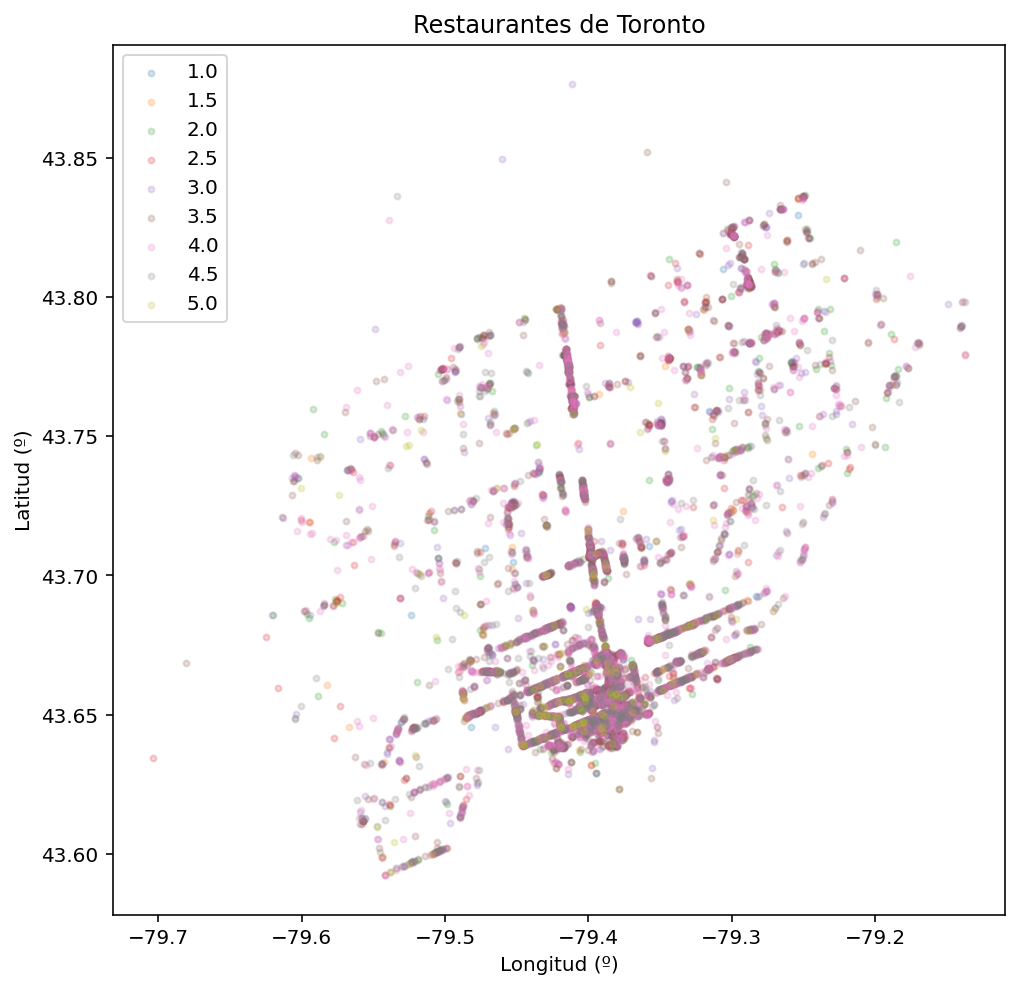

In [24]:
plt.figure(figsize=(8,8))
for ss in np.unique(stars):
    plt.scatter(xy_toronto[stars==ss,0], xy_toronto[stars==ss,1],marker='.',alpha=0.2,label=repr(ss))
plt.legend()
plt.xlabel('Longitud (º)')
_=plt.ylabel('Latitud (º)')
_=plt.title('Restaurantes de Toronto')

En primer lugar recordamos los resultados que obterndríamos usando kNN como en la sesión de introducción del curso

In [25]:
from sklearn.neighbors import KNeighborsRegressor

X_train = restaurantes_train.loc[:,['latitude','longitude','log10_review_count']].values
Y_train = restaurantes_train['stars'].values
X_test = restaurantes_test.loc[:,['latitude','longitude','log10_review_count']].values
Y_test = restaurantes_test['stars'].values

v_k = [1,5,10,25,50,100,250,500] # some values for the number of neighbours
v_weights = ['uniform','distance'] # combination of each neighbour vote
knn_params = {'n_neighbors':v_k,
             'weights':v_weights}
grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid=knn_params, cv=5)
grid_knn.fit(X_train, Y_train)

print("Score with the training data R^2={0:.4f}".format(grid_knn.score(X_train, Y_train)))
print("Score with the test data R^2={0:.4f}".format(grid_knn.score(X_test, Y_test)))
print("Hyperparameters choosen with cross-validation")
print(grid_knn.best_params_)


Score with the training data R^2=0.0538
Score with the test data R^2=0.0465
Hyperparameters choosen with cross-validation
{'n_neighbors': 100, 'weights': 'uniform'}


El primer paso para incorporar la información de localización al modelo lineal consiste en dividir la ciudad en celdas de diferentes tamaños para ganar intuiciones acerca de los tamaños de celda que pueden valernos. Para esta división nos apoyamos en [`KBinsDiscretizer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html), que nos divide un rango continuo en bins siguiendo diferentes estrategias

In [26]:
from sklearn.preprocessing import KBinsDiscretizer

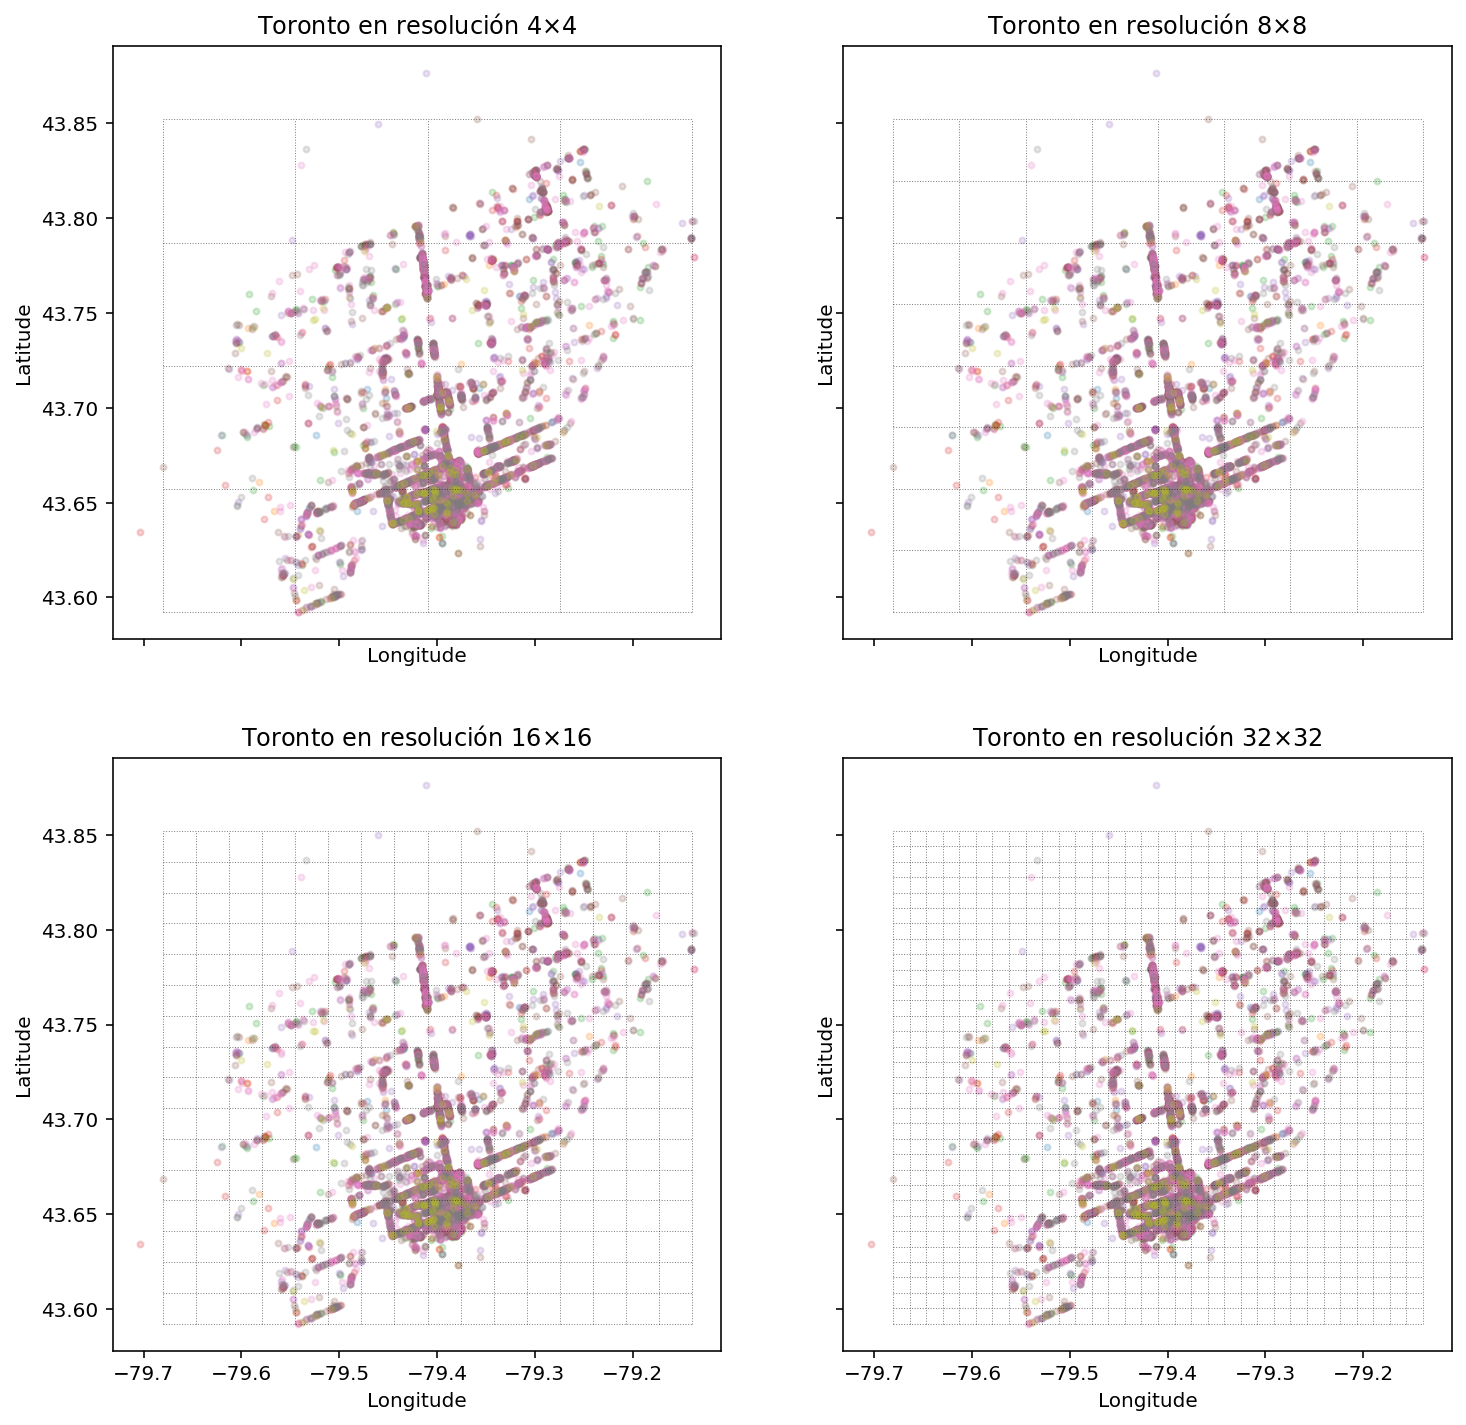

In [27]:
nbins = [4,8,16,32] # numeros de celda por cada dimensión
nrows = 2
ncols = 2
kk = 0
ff,aa = plt.subplots(nrows, ncols,sharex=True, sharey=True,figsize=(12,12))
for rr in range(nrows):
    for cc in range(ncols):
        ax = aa[rr][cc]
        for ss in np.unique(stars):
            ax.scatter(xy_toronto[stars==ss,0], xy_toronto[stars==ss,1],marker='.',alpha=0.2,label=repr(ss))
        n_bins = nbins[kk]
        # partir el mapa de Toronto en n_bins x n_bins celdas usando el conjunto de entrenamiento
        # strategy=uniform quiere decir que las celdas sean igual de grandes en área
        celdas = KBinsDiscretizer(n_bins=n_bins,
                                encode='ordinal',
                 strategy='uniform')
        celdas.fit(restaurantes_train[['longitude','latitude']].values)
        for bb in range(len(celdas.bin_edges_[0])):
            ax.plot([celdas.bin_edges_[0][bb], celdas.bin_edges_[0][bb]],
                   [celdas.bin_edges_[1][0], celdas.bin_edges_[1][-1]],
                   color='black',linestyle=':', linewidth=.5, alpha=0.5)
            ax.plot([celdas.bin_edges_[0][0], celdas.bin_edges_[0][-1]],
                    [celdas.bin_edges_[1][bb], celdas.bin_edges_[1][bb]],
                   color='black',linestyle=':', linewidth=.5, alpha=0.5)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title('Toronto en resolución {0:d}$\\times${0:d}'.format(n_bins))
        kk += 1    

La aplicación de *feature templates* tiene que programarse *ad hoc* para cada tarea. El siguiente código se apoya en `KBinsDiscretizer` para automatizar la generación de las rejillas y codificar cada restaurante con un diccionario que tiene `True` en los valores de las celdas que lo contienen. Las celdas que no lo contienen no se le añaden al diccionario para llegar a una codificación eficiente.

In [28]:
class geo_feature_template(object):
    def __init__(self, 
                 n_bins = 4, 
                 encode='ordinal',
                 strategy='uniform'):
        self.kb = KBinsDiscretizer(n_bins=n_bins,
                                   encode=encode, 
                                   strategy=strategy)
    def fit(self, x):
        # aprende los límites de cada rejilla con los datos en x
        self.kb.fit(x)
        self.bin_edges_ = self.kb.bin_edges_
        
    def transform(self, x):
        # por cada fila de x devuelve un diccionario disperso donde la clave codifica la posición de la celda
        # y el valor es True porque el restaurante está dentro de la celda
        n = x.shape[0]
        d_list = []
        bins = self.kb.transform(x)
        for bb in bins:
            b0 = int(bb[0])
            b1 = int(bb[1])
            key = "latitude_{0:.3f}_{1:.3f}_".format(self.bin_edges_[0][b0],
                                               self.bin_edges_[0][b0+1])
            key+="longitude_{0:.3f}_{1:.3f}".format(self.bin_edges_[1][b1],
                                               self.bin_edges_[1][b1+1])
            value = True
            d_list.append({key:value})
        return np.array(d_list)
    def fit_transform(self, x):
        self.kb.fit(x)
        self.bin_edges_ = self.kb.bin_edges_
        return self.transform(x)
    

La siguiente función fusiona diccionarios con rejillas de diferente resolución

In [29]:
def merge_dicts_in_list(ld1, ld2):
    # ld1: lista de diccionarios (uno por cada restaurante) 
    # ld2: lista de diccionarios (uno por cada restaurante) 
    # las listas deben estar alineadas!! es decir, el elemento i de cada lista debe ser el mismo restaurante!!
    for ii, dd in enumerate(ld1):
        dd.update(ld2[ii])


In [30]:
gft = geo_feature_template(n_bins=128)
geo_train = gft.fit_transform(restaurantes_train[['longitude','latitude']].values)
geo_test = gft.transform(restaurantes_test[['longitude','latitude']].values)

In [31]:
restaurantes_train[['longitude','latitude']].head(3)

,longitude,latitude
3129,-79.288232,43.784078
84653,-79.373855,43.648492
186965,-79.419003,43.638121


In [32]:
geo_train[:3]

array([{'latitude_-79.291_-79.287_longitude_43.783_43.785': True},
       {'latitude_-79.376_-79.372_longitude_43.647_43.649': True},
       {'latitude_-79.422_-79.418_longitude_43.637_43.639': True}],
      dtype=object)

El siguiente código genera las rejillas $64\times 64$, $32\times 32$ y  $16\times 16$ y las añade al diccionario que tiene la rejilla $128\times 128$.

In [33]:
for rr in [64,32,16]:
    mi_geo_transf = geo_feature_template(n_bins=rr)
    mi_geo = mi_geo_transf.fit_transform(restaurantes_train[['longitude','latitude']].values)
    merge_dicts_in_list(geo_train, mi_geo)
    merge_dicts_in_list(geo_test, mi_geo_transf.transform(restaurantes_test[['longitude','latitude']].values))
    

In [34]:
geo_train[0]

{'latitude_-79.291_-79.287_longitude_43.783_43.785': True,
 'latitude_-79.291_-79.283_longitude_43.783_43.787': True,
 'latitude_-79.291_-79.274_longitude_43.779_43.787': True,
 'latitude_-79.308_-79.274_longitude_43.771_43.787': True}

Aplicamos `DictVectorizer` para codificar *one-hot* la pertenencia de cada restaurante a cada celda

In [35]:
gg = DictVectorizer(sparse=False)
casillas_train = gg.fit_transform(geo_train)
casillas_test = gg.transform(geo_test)

Modelo lineal solo con conteos de revisiones

In [36]:
X_train = restaurantes_train['log10_review_count'].values.reshape(-1,1) # column vector, 1 feature and many rows
# Training set targets
Y_train = restaurantes_train['stars'].values
# Test set observations
X_test = restaurantes_test['log10_review_count'].values.reshape(-1,1)
# Test set targets
Y_test = restaurantes_test['stars'].values

In [37]:
linear_model = Ridge(alpha=0.001).fit(X_train, Y_train)
print("Score with the training data R^2={0:.4f}".format(linear_model.score(X_train, Y_train)))
print("Score with the test data R^2={0:.4f}".format(linear_model.score(X_test, Y_test)))


Score with the training data R^2=0.0318
Score with the test data R^2=0.0379


Añadiendo la localización al modelo lineal

In [38]:
X_train = np.nan_to_num(np.hstack((X_train, casillas_train)))
X_test = np.nan_to_num(np.hstack((X_test, casillas_test)))


In [39]:
v_alpha = [.1, 1, 10, 100, 1000]
grid_lr = GridSearchCV(Ridge(), param_grid={'alpha':v_alpha})
grid_lr.fit(X_train, Y_train)
linear_model = grid_lr.best_estimator_
print(grid_lr.best_params_)
print("Score with the training data R^2={0:.4f}".format(linear_model.score(X_train, Y_train)))
print("Score with the test data R^2={0:.4f}".format(linear_model.score(X_test, Y_test)))

print("")

print("w0 = {0:.4f}".format(linear_model.intercept_))
nombre_feature = ['log10_review_count']
nombre_feature += gg.get_feature_names()
pesos = linear_model.coef_
orden = np.argsort(np.absolute(pesos))[::-1]
for ii in orden[:20]:
    print("peso {0} = {1:.4f}".format(nombre_feature[ii], pesos[ii]))
 

{'alpha': 100}
Score with the training data R^2=0.1100
Score with the test data R^2=0.0757

w0 = 3.1577
peso log10_review_count = 0.2315
peso latitude_-79.444_-79.410_longitude_43.641_43.657 = 0.1230
peso latitude_-79.342_-79.308_longitude_43.673_43.690 = 0.1131
peso latitude_-79.410_-79.376_longitude_43.657_43.673 = -0.1045
peso latitude_-79.410_-79.376_longitude_43.706_43.722 = -0.0965
peso latitude_-79.410_-79.393_longitude_43.649_43.657 = 0.0936
peso latitude_-79.444_-79.410_longitude_43.657_43.673 = 0.0882
peso latitude_-79.308_-79.274_longitude_43.803_43.820 = -0.0879
peso latitude_-79.393_-79.376_longitude_43.641_43.649 = -0.0853
peso latitude_-79.410_-79.401_longitude_43.649_43.653 = 0.0820
peso latitude_-79.410_-79.376_longitude_43.625_43.641 = -0.0761
peso latitude_-79.435_-79.427_longitude_43.649_43.653 = 0.0734
peso latitude_-79.444_-79.435_longitude_43.637_43.641 = 0.0733
peso latitude_-79.444_-79.410_longitude_43.755_43.771 = -0.0721
peso latitude_-79.427_-79.410_longitud

La precisión en términos de $R^2$ mejora respecto de no usar información de localización y con respecto al modelo basado en kNN. Podemos analizar en más detalle las celdas que obtienen los pesos más altos 

In [40]:
orden[1:5]

array([1436,  631, 1162, 1165], dtype=int64)

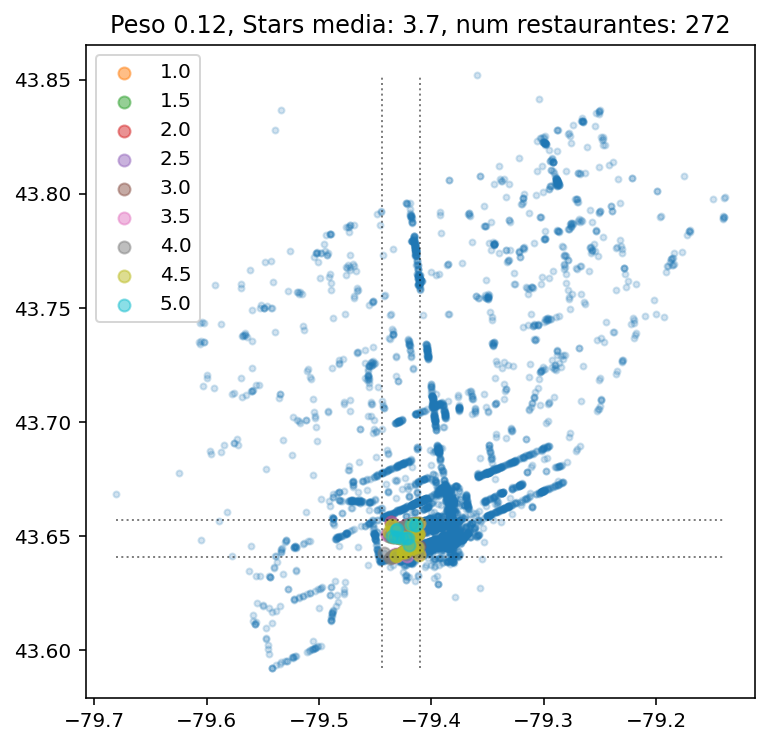

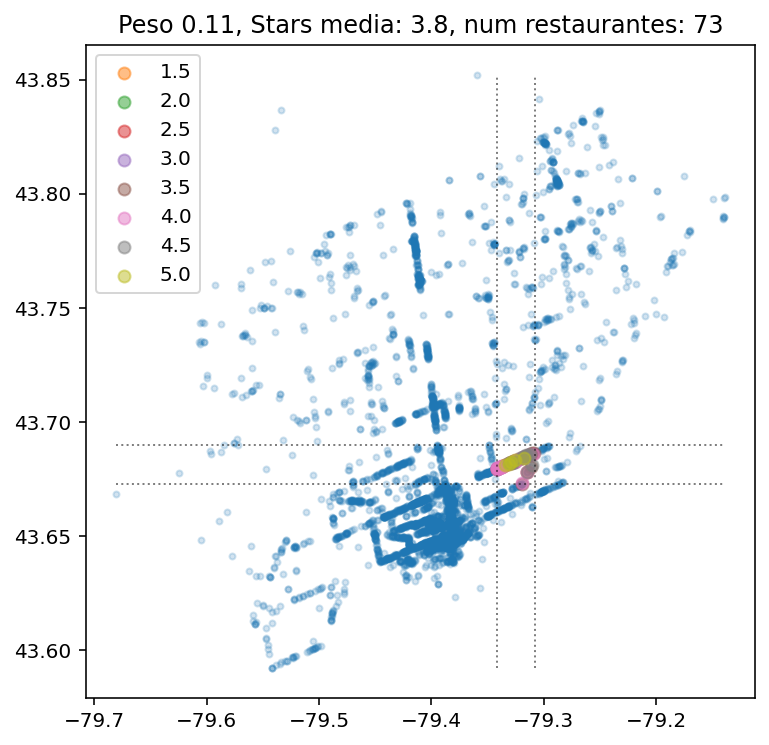

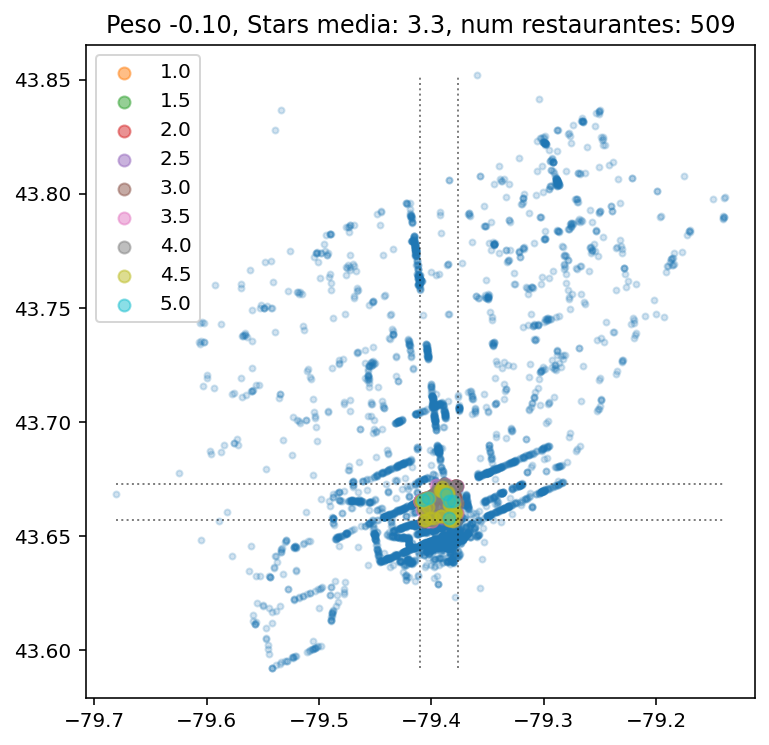

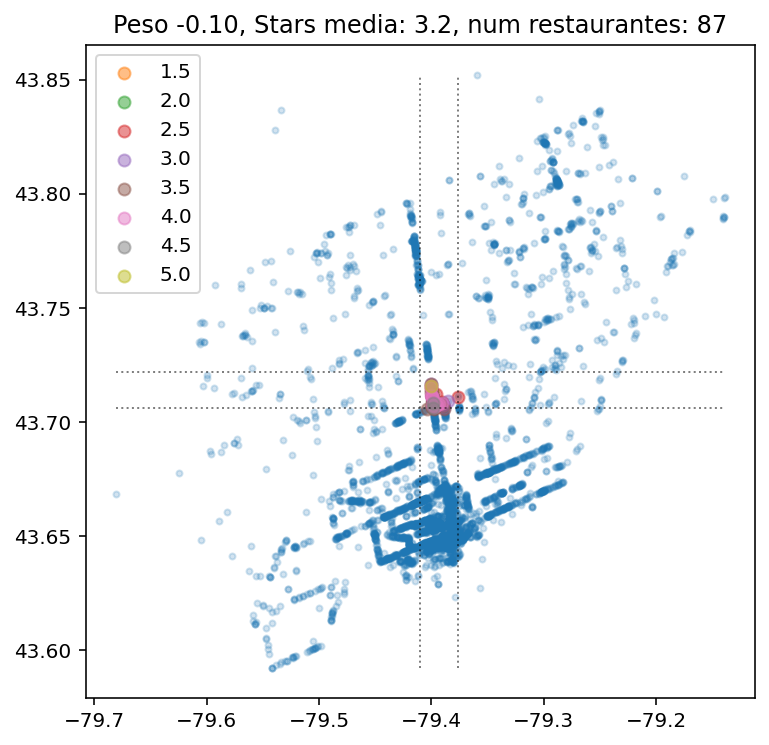

In [41]:
for oo in orden[1:5]:
    plt.figure(figsize=(6,6))
    plt.scatter(restaurantes_train['longitude'].values,
               restaurantes_train['latitude'].values, marker='.',alpha=0.2)
    x1 = float(nombre_feature[oo].split("_")[1])
    x2 = float(nombre_feature[oo].split("_")[2])
    y1 = float(nombre_feature[oo].split("_")[4])
    y2 = float(nombre_feature[oo].split("_")[5])
    plt.plot([x1, x1],
                   [gft.bin_edges_[1][0], gft.bin_edges_[1][-1]],
                   color='black',linestyle=':', linewidth=1, alpha=0.5)
    plt.plot([celdas.bin_edges_[0][0], celdas.bin_edges_[0][-1]],
                    [y1, y1],color='black',linestyle=':', linewidth=1, alpha=0.5)
    plt.plot([x2, x2],
                   [gft.bin_edges_[1][0], gft.bin_edges_[1][-1]],
                   color='black',linestyle=':', linewidth=1, alpha=0.5)
    plt.plot([celdas.bin_edges_[0][0], celdas.bin_edges_[0][-1]],
                    [y2, y2],color='black',linestyle=':', linewidth=1, alpha=0.5)
    
    cuales = np.where(X_train[:,oo]==1)[0]
    rr_df = restaurantes_train.iloc[cuales]
    mi_Stars = rr_df['stars'].values
    for ss in np.unique(mi_Stars):
        plt.scatter(rr_df.loc[rr_df['stars']==ss,'longitude'],
                rr_df.loc[rr_df['stars']==ss,'latitude'],
                marker='o',alpha=0.5,label=repr(ss))
    plt.title('Peso {0:.2f}, Stars media: {1:.1f}, num restaurantes: {2:d}'.format(pesos[oo], 
                                                                                   np.mean(rr_df['stars'].values),
                                                                                  len(cuales)))
    plt.legend()

Combinando la información de los atributos con la localización

In [42]:
attr_train = v.transform(restaurantes_train['flat_attributes'].values)
attr_test = v.transform(restaurantes_test['flat_attributes'].values)

Conteos más atributos 

In [43]:
X_train = restaurantes_train['log10_review_count'].values.reshape(-1,1) # column vector, 1 feature and many rows
X_train = np.nan_to_num(np.hstack((X_train,  attr_train)))
# Training set targets
Y_train = restaurantes_train['stars'].values
# Test set observations
X_test = restaurantes_test['log10_review_count'].values.reshape(-1,1)
X_test = np.nan_to_num(np.hstack((X_test,  attr_test)))
# Test set targets
Y_test = restaurantes_test['stars'].values

In [44]:
v_alpha = [.1, 1, 10, 100, 1000]
grid_lr = GridSearchCV(Ridge(), param_grid={'alpha':v_alpha})
grid_lr.fit(X_train, Y_train)
linear_model = grid_lr.best_estimator_
print(grid_lr.best_params_)
print("Score with the training data R^2={0:.4f}".format(linear_model.score(X_train, Y_train)))
print("Score with the test data R^2={0:.4f}".format(linear_model.score(X_test, Y_test)))

print("")

{'alpha': 100}
Score with the training data R^2=0.1228
Score with the test data R^2=0.1224



In [45]:
print("w0 = {0:.4f}".format(linear_model.intercept_))
nombre_feature = ['log10_review_count']
nombre_feature += gg.get_feature_names()
nombre_feature += v.get_feature_names()

pesos = linear_model.coef_
orden = np.argsort(np.absolute(pesos))[::-1]
for ii in orden[:20]:
    print("peso {0} = {1:.4f}".format(nombre_feature[ii], pesos[ii]))
 

w0 = 3.3312
peso log10_review_count = 0.2135
peso latitude_-79.236_-79.232_longitude_43.757_43.759 = -0.2129
peso latitude_-79.240_-79.207_longitude_43.738_43.755 = -0.1696
peso latitude_-79.240_-79.236_longitude_43.791_43.793 = -0.1678
peso latitude_-79.236_-79.232_longitude_43.720_43.722 = -0.1440
peso latitude_-79.240_-79.207_longitude_43.803_43.820 = -0.1409
peso latitude_-79.240_-79.232_longitude_43.738_43.742 = 0.1142
peso latitude_-79.236_-79.232_longitude_43.722_43.724 = 0.1052
peso latitude_-79.207_-79.173_longitude_43.771_43.787 = 0.1035
peso latitude_-79.240_-79.224_longitude_43.779_43.787 = 0.1030
peso latitude_-79.240_-79.224_longitude_43.738_43.747 = -0.1028
peso latitude_-79.240_-79.224_longitude_43.714_43.722 = -0.0917
peso latitude_-79.224_-79.215_longitude_43.738_43.742 = -0.0909
peso latitude_-79.240_-79.232_longitude_43.803_43.807 = 0.0906
peso latitude_-79.207_-79.190_longitude_43.763_43.771 = 0.0868
peso latitude_-79.236_-79.232_longitude_43.805_43.807 = -0.0843
p

Conteos más atributos más localización mejora sensiblemente cualquiera de las dos fuentes tratadas por separado

In [46]:
X_train = restaurantes_train['log10_review_count'].values.reshape(-1,1) # column vector, 1 feature and many rows
X_train = np.nan_to_num(np.hstack((X_train, casillas_train, attr_train)))
# Training set targets
Y_train = restaurantes_train['stars'].values
# Test set observations
X_test = restaurantes_test['log10_review_count'].values.reshape(-1,1)
X_test = np.nan_to_num(np.hstack((X_test, casillas_test, attr_test)))
# Test set targets
Y_test = restaurantes_test['stars'].values

grid_lr.fit(X_train, Y_train)
linear_model = grid_lr.best_estimator_
print(grid_lr.best_params_)
print("Score with the training data R^2={0:.4f}".format(linear_model.score(X_train, Y_train)))
print("Score with the test data R^2={0:.4f}".format(linear_model.score(X_test, Y_test)))

print("")

print("w0 = {0:.4f}".format(linear_model.intercept_))
nombre_feature = ['log10_review_count']
nombre_feature += gg.get_feature_names()
nombre_feature += v.get_feature_names()

pesos = linear_model.coef_
orden = np.argsort(np.absolute(pesos))[::-1]
for ii in orden[:20]:
    print("peso {0} = {1:.4f}".format(nombre_feature[ii], pesos[ii]))
 

{'alpha': 100}
Score with the training data R^2=0.1903
Score with the test data R^2=0.1530

w0 = 3.3322
peso log10_review_count = 0.2325
peso NoiseLevel=u'very_loud' = -0.1934
peso RestaurantsAttire=u'casual' = -0.1735
peso empty_attributes = -0.1580
peso RestaurantsDelivery = -0.1396
peso NoiseLevel=u'loud' = -0.1281
peso WheelchairAccessible = 0.1222
peso latitude_-79.444_-79.410_longitude_43.641_43.657 = 0.1155
peso latitude_-79.342_-79.308_longitude_43.673_43.690 = 0.1057
peso RestaurantsPriceRange2=2 = -0.0976
peso RestaurantsTableService = 0.0957
peso WiFi=u'free' = 0.0941
peso latitude_-79.410_-79.376_longitude_43.657_43.673 = -0.0940
peso NoiseLevel=u'quiet' = 0.0937
peso latitude_-79.308_-79.274_longitude_43.803_43.820 = -0.0915
peso Caters = 0.0910
peso RestaurantsGoodForGroups = -0.0871
peso latitude_-79.393_-79.376_longitude_43.641_43.649 = -0.0870
peso latitude_-79.410_-79.393_longitude_43.649_43.657 = 0.0862
peso RestaurantsAttire='casual' = -0.0846


## 2.5 Feature Templates con información de fechas y horas

La obtención de caracteristicas que capturen información necesaria para representar patrones relacionados con cómo se distributyen las observaciones a lo largo del tiempo también puede llevarse a cabo mediante *feature templates*. En este caso el dato crudo que vamos a explotar es la marca temporal *timestamp* en la que sucede la observación. 

En general un *timestamp* contiene información sobre fecha y hora. Los campos que esperamos encotrar son:
- año
- mes
- día
- hora
- minuto
- segundo (con precisión de milisegundos o más fina)

Mediante la aplicación de *feature templates* sobre marcas temporales podremos recuperar información relevante a:
- día:
    - mañana, tarde, noche
    - horario comercial, fuera de  horario
- semana:
    - día de la semana
    - día laborable o fin de semana
    - primeros, mediados o finales de semana
- mes: 
    - primeros, mediados o finales de mes
- anual:
    - Saber el trimestre, cuatrimestre, estación, etc
    
    
Extraer esta información es más o menos inmediato de automatizar. Hay otras informaciones como "festivo nacional", "vacaciones escolares", "puente", etc para las que serían necesario cruzar con un calendarios local. 



### Dataset sobre el uso de bicicletas municipales en Seúl

La siguiente celda carga un cojunto de datos sobre la utilización del servicio público de alquiler de bicicletas en Seúl. El *target* consiste en predecir el número de bicicletas que se van a alquilar en una hora en función de variables temporales y de climatología.

Nos vamos a centrar sobre todo en encontrar patrones temporales.

In [47]:
seoul_bikes_df= pd.read_csv('data_seoul_bikes.csv', index_col=0, header=0, parse_dates=['Timestamp'],dtype={'Rented Bike Count': int,
                                                                               'Temperature(C)':float, 
                                                                               'Humidity(%)':float,
                                                                               'Wind speed (m/s)':float, 
                                                                               'Visibility (10m)':float, 
                                                                               'Dew point temperature(C)':float,
                                                                               'Solar Radiation (MJ/m2)':float, 
                                                                               'Rainfall(mm)':float,
                                                                               'Snowfall (cm)':float,
                                                                               'Seasons':str,
                                                                               'Holiday':str, 
                                                                               'Functioning Day':str})

In [48]:
seoul_bikes_df.sample(4)

,Timestamp,Functioning Day,Holiday,Seasons,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Rented Bike Count
2537,2018-03-16 17:00:00,Yes,No Holiday,Spring,11.2,30.0,1.5,2000.0,-5.7,1.44,0.0,0.0,1160
4528,2018-07-06 16:00:00,Yes,No Holiday,Summer,29.3,41.0,2.0,905.0,14.6,1.95,0.0,0.0,1442
5971,2018-06-08 19:00:00,Yes,No Holiday,Summer,32.2,65.0,0.8,1894.0,24.7,0.10,0.0,0.0,1548
2051,2018-02-24 11:00:00,Yes,No Holiday,Winter,2.2,50.0,2.4,608.0,-7.1,1.10,0.0,0.0,298


In [49]:
seoul_bikes_df.tail()

,Timestamp,Functioning Day,Holiday,Seasons,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Rented Bike Count
8755,2018-11-30 19:00:00,Yes,No Holiday,Autumn,4.2,34.0,2.6,1894.0,-10.3,0.0,0.0,0.0,1003
8756,2018-11-30 20:00:00,Yes,No Holiday,Autumn,3.4,37.0,2.3,2000.0,-9.9,0.0,0.0,0.0,764
8757,2018-11-30 21:00:00,Yes,No Holiday,Autumn,2.6,39.0,0.3,1968.0,-9.9,0.0,0.0,0.0,694
8758,2018-11-30 22:00:00,Yes,No Holiday,Autumn,2.1,41.0,1.0,1859.0,-9.8,0.0,0.0,0.0,712
8759,2018-11-30 23:00:00,Yes,No Holiday,Autumn,1.9,43.0,1.3,1909.0,-9.3,0.0,0.0,0.0,584


#### disclaimer

Solo tenemos un año de información, así que no vamos a emplear el modelo con fines predictivos explícitamente, sino como ejemplo para ilustrar cómo se aplican las plantillas de características a información de fechas y horas.

In [50]:
# En primer lugar dividimos los datos en las particiones de entrenamiento y test correspondientes.

In [51]:
from sklearn.preprocessing import StandardScaler
seoul_train, seoul_test = train_test_split(seoul_bikes_df, 
                                                         test_size=0.2, 
                                                         random_state=42)

Ytrain = seoul_train['Rented Bike Count'].values
Ytest = seoul_test['Rented Bike Count'].values




Como primera aproximación aprendemos un modelo lineal **"estacionario"**, es decir, descartando toda la información temporal y empleando únicamente las variables climatológicas (que están obviamente correlacionadas con los patrones temporales, pero no explícitamente).

In [52]:

continuas = ['Temperature(C)',
             'Humidity(%)','Wind speed (m/s)',
             'Visibility (10m)',
             'Dew point temperature(C)',
             'Solar Radiation (MJ/m2)',
             'Rainfall(mm)',
             'Snowfall (cm)']

# escalamos los datos
XX = seoul_train[continuas].values
sc = StandardScaler().fit(XX)
Xtrain_c = sc.transform(XX)
Xtest_c = sc.transform(seoul_test[continuas].values)


v_alpha = [1e-3, 1e-2, 1e-1, 1, 10, 100,1000,1e4]
grid_rr = GridSearchCV(Ridge(),{'alpha':v_alpha})
grid_rr.fit(Xtrain_c, Ytrain)
print(grid_rr.best_params_)
print('R^2 train: {0:.3f}'.format(grid_rr.score(Xtrain_c, Ytrain)))
print('R^2 test: {0:.3f}'.format(grid_rr.score(Xtest_c, Ytest)))

{'alpha': 10}
R^2 train: 0.395
R^2 test: 0.411


A continuación vamos a desplegar diferentes *feature templates* para enriquecer el modelo lineal con patrones dependientes de la temporalidad de las observaciones. Comenzamos con patrones que capturen información semanal.

### Día de la semana

El objetivo de esta *feature template* es codificar una función que para cada observación del conjunto de datos nos devuelva un diccionario con una clave indicando el día de la semana y otra indicando si es fin de semana o día laborable:
- `Monday`, `Tuesday`, `Wednesday`,`Thursday`,`Friday`,`Saturday`,`Sunday`
- `WorkDay`,`Weekend`

Por ejemplo:
$$
x=\mbox{ 5 marzo 2021 } \Rightarrow \boldsymbol \phi(x) = \{\mbox{Friday : True,} \mbox{WorkDay : True} \}
$$

asumimos que el resto de *values* estarán en `False` y por ello no se generan explícitamente.

In [53]:
import datetime as dt
print(dt.datetime.today())
dt.datetime.today().weekday()

2021-03-05 11:25:51.488401


4

La siguiente celda contiene la función `dict_week_day` que nos devuelve ese diccionario cuando recibe un objeto python `datetime` como argumento.

In [54]:
lista_dias = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
def dict_week_day(t):
    dow = t.weekday()
    d = {lista_dias[dow]:True}
    if dow<5:
        d.update({'WorkDay':True})
    else:
        d.update({'Weekend':True})
    return d

In [55]:
dict_week_day(dt.datetime.today())

{'Friday': True, 'WorkDay': True}

Apoyandonos en `dict_week_day` vamos a programar el despliegue de la *feature template* para extraer información de la semana en el conjunto de datos:
1. Construir el diccionario con la información de la semana para cada registro del conjunto de entrenamiento y de test
2. Usar `DictVectorizer` para codificar *one-hot* la información de semana
3. Aprender el modelo lineal enriquecido con estas nuevas features

In [56]:
# desplegar feature templates
dict_semana_train = seoul_train['Timestamp'].apply(dict_week_day)
dict_semana_test = seoul_test['Timestamp'].apply(dict_week_day)

# Llamar a DictVectorizer
dv_semana = DictVectorizer(sparse=False)
print("Solo dias")
Xtrain_w = dv_semana.fit_transform(dict_semana_train.values)
Xtest_w = dv_semana.transform(dict_semana_test.values)

# Entrenar modelo lineal *solo con información de la semana*

grid_rr = GridSearchCV(Ridge(),{'alpha':v_alpha})
grid_rr.fit(Xtrain_w, Ytrain)
print(grid_rr.best_params_)
print('R^2 train: {0:.3f}'.format(grid_rr.score(Xtrain_w, Ytrain)))
print('R^2 test: {0:.3f}'.format(grid_rr.score(Xtest_w, Ytest)))


# Entrenar modelo lineal *enriquecido con información de la semana*

print("\nDias + variables continuas")
Xtrain = np.hstack((Xtrain_c, Xtrain_w))
Xtest = np.hstack((Xtest_c, Xtest_w))
grid_rr.fit(Xtrain, Ytrain)
print(grid_rr.best_params_)
print('R^2 train: {0:.3f}'.format(grid_rr.score(Xtrain, Ytrain)))
print('R^2 test: {0:.3f}'.format(grid_rr.score(Xtest, Ytest)))
print("")
print("w0 = {0:.4f}".format(grid_rr.best_estimator_.intercept_))
nombre_feature = continuas[:]
nombre_feature += dv_semana.get_feature_names()

pesos = grid_rr.best_estimator_.coef_
orden = np.argsort(np.absolute(pesos))[::-1]
for ii in orden:
    print("peso {0} = {1:.4f}".format(nombre_feature[ii], pesos[ii]))
 

Solo dias
{'alpha': 100}
R^2 train: 0.005
R^2 test: -0.000

Dias + variables continuas
{'alpha': 10}
R^2 train: 0.399
R^2 test: 0.413

w0 = 697.4105
peso Temperature(C) = 408.7788
peso Humidity(%) = -222.8624
peso Solar Radiation (MJ/m2) = -103.3027
peso Sunday = -58.5818
peso Rainfall(mm) = -54.6381
peso Wind speed (m/s) = 53.7254
peso Tuesday = -46.0214
peso Saturday = 39.6243
peso Wednesday = 30.0417
peso Friday = 24.1426
peso Weekend = -18.9575
peso WorkDay = 18.9575
peso Snowfall (cm) = 17.6491
peso Thursday = 17.2546
peso Dew point temperature(C) = 16.3597
peso Monday = -6.4601
peso Visibility (10m) = -4.0080


No parece que la información de la semana contribuya mucho a mejorar el modelo

### Información mensual

Adaptad el procesamiento anterior para programar un despliegue de *feature templates* que extraiga información sobre el mes. Concretamente el mes en el que se está y el cuatrimestre:
- `Jan`, `Feb`,`Mar`,`Apr`,`May`,`Jun`,`Jul`,`Aug`, `Sep`, `Oct`, `Nov`, `Dec`
- `Q1`, `Q2`,`Q3`,`Q4`

Para ello:
- Cree una función `dict_month` análoga a `dict_week_day`
- Aplique *feature templates* a los datos
- Invoque `DictVectorizer`
- Aprenda el modelo lineal correspondiente

In [82]:
#############
# YOUR CODE #
#############
lista_meses = ['Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec']
quarter = ['Q1','Q2','Q3','Q4']
def dict_month(t):
    dow = t.month - 1
    d = {lista_meses[dow]:True}
    if dow<4:
        d.update({quarter[0]:True})
    elif dow<7:
        d.update({quarter[1]:True})
    elif dow<10:
        d.update({quarter[2]:True})
    else:
        d.update({quarter[3]:True})
    return d

# desplegar feature templates
dict_semana_train = seoul_train['Timestamp'].apply(dict_month)
dict_semana_test = seoul_test['Timestamp'].apply(dict_month)

# Llamar a DictVectorizer
dv_semana = DictVectorizer(sparse=False)
print("Solo MESES")
Xtrain_w = dv_semana.fit_transform(dict_semana_train.values)
Xtest_w = dv_semana.transform(dict_semana_test.values)

# Entrenar modelo lineal *solo con información de la semana*

grid_rr = GridSearchCV(Ridge(),{'alpha':v_alpha})
grid_rr.fit(Xtrain_w, Ytrain)
print(grid_rr.best_params_)
print('R^2 train: {0:.3f}'.format(grid_rr.score(Xtrain_w, Ytrain)))
print('R^2 test: {0:.3f}'.format(grid_rr.score(Xtest_w, Ytest)))


# Entrenar modelo lineal *enriquecido con información de la semana*

print("\nMESES + variables continuas")
Xtrain = np.hstack((Xtrain_c, Xtrain_w))
Xtest = np.hstack((Xtest_c, Xtest_w))
grid_rr.fit(Xtrain, Ytrain)
print(grid_rr.best_params_)
print('R^2 train: {0:.3f}'.format(grid_rr.score(Xtrain, Ytrain)))
print('R^2 test: {0:.3f}'.format(grid_rr.score(Xtest, Ytest)))
print("")
print("w0 = {0:.4f}".format(grid_rr.best_estimator_.intercept_))
nombre_feature = continuas[:]
nombre_feature += dv_semana.get_feature_names()

pesos = grid_rr.best_estimator_.coef_
orden = np.argsort(np.absolute(pesos))[::-1]
for ii in orden:
    print("peso {0} = {1:.4f}".format(nombre_feature[ii], pesos[ii]))
#################
# END YOUR CODE #
#################

Solo MESES
{'alpha': 10}
R^2 train: 0.095
R^2 test: 0.107

MESES + variables continuas
{'alpha': 10}
R^2 train: 0.424
R^2 test: 0.437

w0 = 710.4976
peso Temperature(C) = 431.5158
peso Humidity(%) = -214.1063
peso Oct = 201.5549
peso Jul = -132.9805
peso Jun = 121.4119
peso Aug = -116.0992
peso Feb = -115.6127
peso Solar Radiation (MJ/m2) = -108.6811
peso Sep = -103.2741
peso Wind speed (m/s) = 56.2008
peso Rainfall(mm) = -55.7013
peso Nov = 55.4984
peso Q1 = -50.6744
peso May = 48.4432
peso Apr = 42.6693
peso Q2 = 36.8747
peso Q4 = 31.6180
peso Mar = 24.9576
peso Dec = -23.8804
peso Snowfall (cm) = 18.8641
peso Q3 = -17.8184
peso Visibility (10m) = 9.6367
peso Dew point temperature(C) = -4.5544
peso Jan = -2.6885


In [74]:
dict_month(dt.datetime.today())

{'Mar': True, 'Q1': True}

In [81]:
# HORAS
def dict_hour(t):
    dow = t.hour
    d = {dow:True}
    return d

# desplegar feature templates
dict_semana_train = seoul_train['Timestamp'].apply(dict_hour)
dict_semana_test = seoul_test['Timestamp'].apply(dict_hour)

# Llamar a DictVectorizer
dv_semana = DictVectorizer(sparse=False)
print("Solo HORAS")
Xtrain_w = dv_semana.fit_transform(dict_semana_train.values)
Xtest_w = dv_semana.transform(dict_semana_test.values)

# Entrenar modelo lineal *solo con información de la semana*

grid_rr = GridSearchCV(Ridge(),{'alpha':v_alpha})
grid_rr.fit(Xtrain_w, Ytrain)
print(grid_rr.best_params_)
print('R^2 train: {0:.3f}'.format(grid_rr.score(Xtrain_w, Ytrain)))
print('R^2 test: {0:.3f}'.format(grid_rr.score(Xtest_w, Ytest)))


# Entrenar modelo lineal *enriquecido con información de la semana*

print("\nHORAS + variables continuas")
Xtrain = np.hstack((Xtrain_c, Xtrain_w))
Xtest = np.hstack((Xtest_c, Xtest_w))
grid_rr.fit(Xtrain, Ytrain)
print(grid_rr.best_params_)
print('R^2 train: {0:.3f}'.format(grid_rr.score(Xtrain, Ytrain)))
print('R^2 test: {0:.3f}'.format(grid_rr.score(Xtest, Ytest)))
print("")
print("w0 = {0:.4f}".format(grid_rr.best_estimator_.intercept_))
nombre_feature = continuas[:]
nombre_feature += dv_semana.get_feature_names()

pesos = grid_rr.best_estimator_.coef_
orden = np.argsort(np.absolute(pesos))[::-1]
for ii in orden:
    print("peso {0} = {1:.4f}".format(nombre_feature[ii], pesos[ii]))

Solo HORAS
{'alpha': 1}
R^2 train: 0.294
R^2 test: 0.282

HORAS + variables continuas
{'alpha': 1}
R^2 train: 0.580
R^2 test: 0.592

w0 = 706.0806
peso 18 = 705.3501
peso 19 = 483.5317
peso 20 = 406.6314
peso 4 = -401.8573
peso 8 = 399.2012
peso 21 = 388.5694
peso 5 = -385.1929
peso 3 = -335.6919
peso 22 = 305.6070
peso 17 = 279.9538
peso 11 = -260.2714
peso 2 = -251.3164
peso 10 = -243.9106
peso Temperature(C) = 230.2613
peso 6 = -229.5363
peso 13 = -224.3054
peso 14 = -223.3832
peso 12 = -218.6226
peso Humidity(%) = -160.8857
peso 1 = -144.7862
peso 15 = -132.4200
peso Dew point temperature(C) = 119.7082
peso 7 = 73.0503
peso Solar Radiation (MJ/m2) = 65.2261
peso Rainfall(mm) = -63.0953
peso 23 = 54.6108
peso 0 = -50.5024
peso Visibility (10m) = 16.4491
peso Wind speed (m/s) = -12.7471
peso Snowfall (cm) = 7.9935
peso 16 = 4.4782
peso 9 = 0.8128


### Dia del mes
Adaptad el procesamiento anterior para programar un despliegue de *feature templates* que extraiga información sobre el día dentor del mes. Concretamente el mes en el que se está y el cuatrimestre:
- `Early`, `Mid`, `Late` 
- `1`, `2`, ..., `31`

Cread una función `dict_day` análoga a `dict_week_day`...

In [ ]:
#############
# YOUR CODE #
#############

#################
# END YOUR CODE #
#################

Ahora combine las 3 *feature templates* junto con las variables numéricas en el mismo modelo lineal

In [ ]:
#############
# YOUR CODE #
#############

#################
# END YOUR CODE #
#################

El mejor resultado se obtiene combinando las 3 *feature templates* en el mismo predictor lineal, esto quiere decir que cada fuente de información está siendo contribuyente neta en el modelo.

# 3. Síntesis de características mediante *machine learning*

Además de las *feature templates*, que obtienen juegos de características sintéticas aplicando cálculos más o menos sencillos capaces de extraer patrones de las variables originales, podemos emplear técnicas de aprendizaje automático para el diseño de características sintéticas más sofisticadas.

Nuevamente recordamos que normalmente la ganancia en la riqueza expresiva de las características que se puedan generar con aprendizaje automático puede comprometer parte de la interpretabilidad de los resultados del aprendizaje. En este sentido, las técnicas que vamos a presentar en esta sección pueden considerarse un paso intermedio antes del empleo de *deep learning* para el diseño de características; las técnicas que vamos a presentar a continuación sí permiten controlar algunos parámetros del proceso de diseño de las características que se sintetizan frente a la total automatización del proceso que sucede al emplear *deep learning*.

## 3.1 Síntesis de características mediante *ensembles*

El modo de extraer las predicciones finales en un modelo de conjuntos o *ensemble* consiste en combinar las predicciones individuales efectuadas por los miembros del conjunto en una predicción unificada. En un problema de clasificación la clase de salida para cada observación de test es la moda de las clases predichas por los miembros del conjunto y en un modelo de regresión suele emplearse la media como método para combinar de estas predicciones individuales. 

La predicción basada en la media de las predicciones individuales de los miembros del conjunto puede **asimilarse a un modelo lineal** en el que:
- Las características son las salidas de los miembros del conjunto
- Los pesos son $1/M$ donde $M$ es el tamaño del *ensemble* (número de *weak learners*)

Esta analogía motiva el primer método de síntesis de características, entrenar un número de *weak learners* y usar sus predicciones como características para un modelo lineal. Conceptualmente está relacionado con el *stacking* de clasificadores que vimos en el módulo de *ensembles*, considerando un modelo lineal como *metaclasificador* que combina los clasificadores que actúan directamente sobre las características originales.

Para evitar problemas de *leakage*, es prudente dividir el entrenamiento del modelo global en dos etapas, idealmente cada una con su conjunto de entrenamiento independiente:
1. **Sintetizar características**. Entrenar *weak learners* con  una parte de los datos de entrenamiento. A cada *weak learner* se le proporciona un subconjunto de esa parte de datos de entrenamiento siguiendo un esquema de *bagging*, por ejemplo.

2. Entrenar un **modelo lineal** empleando como características de entrada las salidas de los *weak learners* de la etapa anterior. Estas características se habrán sintentizado a partir de un conjunto de entrenamiento separado del usado en el punto anterior para evitar *leakage*.

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTERMEDIO/features1.png' width=800 />

Vamos a emplear este esquema para resolver el problema de la predicción del alquiler de bicicletas en Seúl

In [ ]:
# Dividimos el conjunto de entrenamiento en dos partes
seoul_train_features, seoul_train_model = train_test_split(seoul_train, 
                                                         test_size=0.5, 
                                                         random_state=42)
Ytrain_features = seoul_train_features['Rented Bike Count'].values
Ytrain_model = seoul_train_model['Rented Bike Count'].values

# Aplicamos el escalado que ya habíamos aprendido
Xtrain_features_c = sc.transform(seoul_train_features[continuas].values)
Xtrain_model_c = sc.transform(seoul_train_model[continuas].values)


### Empleo de árboles de decisión como aprendices débiles

El siguiente código genera 7 ensembles, de tamaños comprendidos entre 10 y 1000 miembros usando árboles de decisión como *weak learners* y un esquema de *bagging* para conseguir los conjuntos de entrenamiento de cada árbol, es decir, 7 *Random Forests*.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
v_arboles = [10,20,50,100,200,500,1000]
max_leaf_nodes = 20
lista_rf  = []
for n_estimators in v_arboles:
    lista_rf.append(RandomForestRegressor(max_leaf_nodes=max_leaf_nodes,
                                         n_estimators = n_estimators,
                                         max_samples=0.5).fit(Xtrain_features_c, 
                                                                          Ytrain_features))
    

En la lista `lista_rf` hemos almacenado cada uno de los ensembles, es decir, cada elemento de `lista_rf` es un *random forest*. Cada uno de estos *random forest* tiene a su vez una lista con los árboles de decisión que lo pueblan. Esta lista es accesible a través del atributo `estimators_`

In [ ]:
lista_rf[0].estimators_

La siguiente celda contiene la función `genera_features`, que recibe una lista de estimadores y un conjunto de datos y **sintetiza características** del siguiente modo:
- una fila por cada elemento (fila) de `X`
- una columna por cada estimador en la lista `lista_estimadores`
- el elemento `Features[i,j]` es el resultado de estimar `X[i,:]` con el estimador `lista_estimadores[j]`

In [ ]:
def genera_features(lista_estimadores, X):
    n_rows = X.shape[0]
    n_cols = len(lista_estimadores)
    Features = np.empty((n_rows, n_cols))
    for jj,estimador in enumerate(lista_estimadores):
        Features[:,jj] = estimador.predict(X)
    return Features

Finalmente la siguiente celda aprende los modelos lineales (notad que usando `Xtrain_model_c` como conjunto para sintetizar *features*, que son datos distintos a los empleados para aprender los *random forest*). 

In [ ]:
r2_random_forest = np.empty(len(v_arboles))
r2_rf = np.empty(len(v_arboles))
for ii,n_estimators in enumerate(v_arboles):
    r2_rf[ii] = lista_rf[ii].score(Xtest_c, Ytest)
    lista_estimadores = lista_rf[ii].estimators_
    print(len(lista_estimadores))
    X_train = genera_features(lista_estimadores, Xtrain_model_c)
    print(X_train.shape)
    sc1 = StandardScaler()
    sc1.fit(X_train)
    X_train = sc1.transform(X_train)
    X_test = sc1.transform(genera_features(lista_estimadores, Xtest_c))
    grid_rr.fit(X_train, Ytrain_model)
    print("{0:d} estimadores".format(n_estimators))
    print(grid_rr.best_params_)
    r2_random_forest[ii] = grid_rr.score(X_test, Ytest)
    print('R^2 train: {0:.3f}'.format(grid_rr.score(X_train, Ytrain_model)))
    print('R^2 test: {0:.3f}'.format(r2_random_forest[ii]))
    print("")

#### Extremely Random Trees
Las características sintetizadas usando *random forest* tienen una motivación para funcionar bien, es decir, para aportar **poder predictivo** y es que no dejan de ser modelos, sencillos, pero orientados a resolver la tarea de predicción.

Si bien para que un *ensemble* basado en *bagging* funcione es necesario exigirle a cada *weak learner* una mínima precisión (del orden de un acierto ligeramente superior al 50% en un problema de clasificación binaria con clases balanceadas), esta restricción se puede **relajar** si consideramos que los árboles se usan para sintetizar características que luego se van a combinar de **un modo más inteligente** que con un promedio, es decir, estas características sintéticas van a alimentar un modelo lineal.

Relajar al máximo los *weak learners* implica no entrenarlos, sino generar árboles aleatorios. De esta manera se ahorran los costes de entrenar cada árbol descansando en que habrá un número suficientemente grande y variado de ellos para que el modelo lineal pueda resolver la tarea.

La clase [ExtraTreesRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html) implementa los *extremely random trees* en *scikit learn*.

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
v_arboles = [10,20,50,100,200,500,1000]
max_leaf_nodes = 20
lista_et  = []
for n_estimators in v_arboles:
    lista_et.append(ExtraTreesRegressor(max_leaf_nodes=max_leaf_nodes,
                                         n_estimators = n_estimators,
                                         max_samples=0.5).fit(Xtrain_features_c, 
                                                                          Ytrain_features))
    

In [ ]:
r2_extremely_random = np.empty(len(v_arboles))
r2_er = np.empty(len(v_arboles))
for ii,n_estimators in enumerate(v_arboles):
    r2_er[ii] = lista_et[ii].score(Xtest_c, Ytest)
    lista_estimadores = lista_et[ii].estimators_
    print(len(lista_estimadores))
    X_train = genera_features(lista_estimadores, Xtrain_model_c)
    print(X_train.shape)
    sc1 = StandardScaler()
    sc1.fit(X_train)
    X_train = sc1.transform(X_train)
    X_test = sc1.transform(genera_features(lista_estimadores, Xtest_c))
    grid_rr.fit(X_train, Ytrain_model)
    print("{0:d} estimadores".format(n_estimators))
    print(grid_rr.best_params_)
    r2_extremely_random[ii] = grid_rr.score(X_test, Ytest)
    print('R^2 train: {0:.3f}'.format(grid_rr.score(X_train, Ytrain_model)))
    print('R^2 test: {0:.3f}'.format(r2_extremely_random[ii]))
    print("")

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(v_arboles, r2_rf, label='Random Forest')
plt.plot(v_arboles, r2_random_forest, label='Sintesis Random Forest + Lineal')
plt.plot(v_arboles, r2_er, label='Extremely random trees')
plt.plot(v_arboles, r2_extremely_random, label='Sintesis Extremely random trees + lineal')
plt.legend()
plt.xlabel('Numero caracteristicas sinteticas/árboles')
plt.ylabel('$R^2$')
plt.xscale('log')

### Empleo de regresores lineales o kNN como aprendices débiles

Además de árboles de decisión podemos probar a sintetizar características con otros *weak learners* como regresores lineales (en el espacio original, claro) o kNN. 

Emplear *weak learners* nos proporciona **diversidad** en las características sintetizadas, lo que enriquece al modelo lineal con mayor capacidad expresiva.

El *weak learner* elegido nos da una idea de cómo son los patrones que puedan capturar estas características.

La clase [BaggingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) nos permite construir estos *ensembles* con el *weak learner* que más se adecúe a nuestros intereses.

In [ ]:

from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
v_arboles = [10,20,50,100,200,500,1000]
max_leaf_nodes = 20
lista_lr  = []
for n_estimators in v_arboles:
    lista_lr.append(BaggingRegressor(base_estimator= KNeighborsRegressor(n_neighbors=10,weights='distance'),
                                         n_estimators = n_estimators,
                                         max_samples=0.5).fit(Xtrain_features_c, 
                                                                          Ytrain_features))
    

In [ ]:
r2_knn = np.empty(len(v_arboles))
for ii,n_estimators in enumerate(v_arboles):
    lista_estimadores = lista_lr[ii].estimators_
    print(len(lista_estimadores))
    X_train = genera_features(lista_estimadores, Xtrain_model_c)
    print(X_train.shape)
    sc1 = StandardScaler()
    sc1.fit(X_train)
    X_train = sc1.transform(X_train)
    X_test = sc1.transform(genera_features(lista_estimadores, Xtest_c))
    grid_rr.fit(X_train, Ytrain_model)
    print("{0:d} estimadores".format(n_estimators))
    print(grid_rr.best_params_)
    print('R^2 train: {0:.3f}'.format(grid_rr.score(X_train, Ytrain_model)))
    print('R^2 test: {0:.3f}'.format(grid_rr.score(X_test, Ytest)))
    print("")
    r2_knn[ii] = grid_rr.score(X_test, Ytest)

Como **ejercicio** podéis sintetizar caracterísiticas usando este esquema pero con regresores lineales como aprendices débiles.

In [ ]:

#############
# YOUR CODE #
#############

#################
# END YOUR CODE #
#################

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(v_arboles, r2_random_forest, label='Sintesis Random Forest + Lineal')
plt.plot(v_arboles, r2_extremely_random, label='Sintesis Extremely random trees + lineal')
plt.plot(v_arboles, r2_knn, label='Sintesis kNN + Lineal')
plt.plot(v_arboles, r2_lm, label='Sintesis Linear Regression  + Lineal')
plt.legend()
plt.xlabel('Numero caracteristicas sinteticas/árboles')
plt.ylabel('$R^2$')
plt.xscale('log')

## 3.2 Características sintéticas basadas en *kernels*

Los modelos basados en kernels (como las SVM) son exactamente **combinaciones lineales** de esas funciones kernels alojadas en algunas de las muestras de entrenamiento (los vectores soporte, en el caso de las SVM). Siguiendo el  punto de vista desarrollado en la subsección anterior, podemos asimilar el **rol de cada una de esas funciones kernel** al desempeñado por los *weak learners* y considerar que cada función kernel es una componente de la **transformación** que define un espacion de características alternativo en el que se aplica un modelo lineal. Concretamente:

+ Solución de un modelo basado en *kernels*, donde $\{(\mathbf x_i, y_i)\}_{i=1}^n$ son los pares observación, *target* que definen el conjunto de entrenamiento y $\mathbf x_t$ es una observación genérica del conjunto de test para la que se desea predecir el target $\mathbf y_t$. Consideramos una salida *blanda* (antes del decisor basado en signo) para unificar clasificación (estaríamos dando la distancia a la frontera de clasificación en el caso de la SVM, no la clase) y regresión.
$$
f(\mathbf x_t) = \sum_{i=1}^n{\alpha_i \kappa(\mathbf x_i,\mathbf x_t) }
$$

+ Esta suma se puede descomponer en un producto escalar
$$
f(\mathbf x_t) = \left[\begin{array}{cccc} \alpha_1 & \alpha_2 & \dots & \alpha_n \end{array}\right] \left[\begin{array}{c} \kappa(\mathbf x_1,\mathbf x_t) \\ \kappa(\mathbf x_2,\mathbf x_t) \\ \vdots \\ \kappa(\mathbf x_n,\mathbf x_t)\end{array}\right] = \mathbf w^\top \boldsymbol \psi(\mathbf x_t) 
$$
+ Los coeficientes del modelo de kernels $\{\alpha_i\}_{i=1}^n$ formarían el vector de pesos del modelo lineal
$$
\mathbf w = \left[\begin{array}{c} \alpha_1 \\ \alpha_2 \\ \vdots \\ \alpha_n \end{array}\right]
$$
+ Las funciones *kernel* $\{\kappa(\mathbf x_i,\mathbf x_t)\}_{i=1}^n$ serían las encargadas de transformar cada observación del espacio de entrada en una observación del espacio de características:
$$
\boldsymbol \psi:\mathbf x_t \in \mathbb R^d \rightarrow \boldsymbol \psi(\mathbf x_t)\in \mathbb R^n
$$
con
$$
\boldsymbol \psi(\mathbf x_t) = \left[\begin{array}{c} \psi_1(\mathbf x_t)=\kappa(\mathbf x_1,\mathbf x_t) \\ \psi_2(\mathbf x_t)=\kappa(\mathbf x_2,\mathbf x_t) \\ \vdots \\ \psi_n(\mathbf x_t)=\kappa(\mathbf x_n,\mathbf x_t)\end{array}\right]
$$

Dado que un *kernel* tiene una interpretación de función de similitud (es asimilable a un producto escalar), cada una de estas $n$ características sintéticas $\psi_i(\mathbf x_t)=\kappa(\mathbf x_i,\mathbf x_t)$  tiene una interpretación en términos  del **parecido de la observación $\mathbf x_t$ a la observación del conjunto de entrenamiento en la que se centra el kernel** que define la característica $i$-ésima: $\mathbf x_i$ .

Alternativamente a esta interpretación de cada función kernel como una característica sintética que mide el parecido con la observación del conjunto de entrenamiento correspondiente, no debemos dejar de tener en cuenta que tenemos una garantía teórica de que cuando seleccionamos una función *kernel* para construir una versión no lineal de un modelo lineal, en realidad estamos eligiendo una transformación a un espacio de características implícito en el que ese kernel calcula productos escalares:

+ Elegir un *kernel* $\kappa_{\phi}(\mathbf x_i, \mathbf x_j)$ implica elegir una transformación $\boldsymbol \phi$ tal que dadas dos observaciones del conjunto de entrenamiento $\mathbf x_i$ y $\mathbf x_j$:
$$
\kappa_{\phi}(\mathbf x_i, \mathbf x_j) = \boldsymbol \phi(\mathbf x_i)^\top\boldsymbol \phi(\mathbf x_j)
$$

En algunos casos puede ser relativamente accesible recuperar la transformación implícita  $\boldsymbol \phi()$, es decir, conocer cada uno de los elementos del vector $\boldsymbol \phi(\mathbf x_i)$ explícitamente, o construir una aproximación a ella.

### Features sintéticas a partir del kernel polinómico

Un *kernel*  polinómico obedede a la expresión
$$
\kappa(\mathbf u, \mathbf v) = (\mathbf u^\top \mathbf v + c)^d
$$ con $c$ y $d$ constantes

Esta expresión se puede desarrollar, vamos a hacerlo para el caso particular en que el grado del polinomio sea $d=2$ y las observaciones tengan dos dimensiones: $\mathbf u, \mathbf v \in \mathbb R^2$. Si las observaciones son en 2 dimensiones, el producto escalar interno del *kernel* puede desarrollarse como:
$$
\mathbf u^\top \mathbf v = u_1v_1 + u_2v_2 
$$

Introduciendo este resultado en el cálculo del *kernel*

$$
(\mathbf u^\top \mathbf v + c)^2 = (u_1v_1 + u_2v_2 + c)^2 = u_1^2v_1^2 + u_2^2v_2^2 + c^2 + 2u_1v_1u_2v_2 + 2u_1v_1c + 2u_2v_2c 
$$

Separamos lo que depende de $\mathbf u$ de lo que depende de $\mathbf v$ en dos vectores:

$$
u_1^2v_1^2 + u_2^2v_2^2 + c^2 + 2u_1v_1u_2v_2 + 2u_1v_1c + 2u_2v_2c = \left[\begin{array}{cccccc}u_1^2 & u_2^2 & c & \sqrt{2}u_1u_2 & \sqrt{2c}u_1 & \sqrt{2c}u_2 \end{array}\right]\left[\begin{array}{c} v_1^2 \\ v_2^2 \\ c \\ \sqrt{2}v_1v_2 \\ \sqrt{2c}v_1 \\ \sqrt{2c}v_2\end{array}\right]
$$

Llamamos $\boldsymbol \phi(\mathbf u)$ al vector que contiene los elementos dependientes de $\mathbf u$ y $\boldsymbol \phi(\mathbf v)$ al que contiene los elementos dependientes de $\mathbf v$.

Luego el kernel $\kappa(\mathbf u, \mathbf v)$ puede descomponerse en el producto escalar de dos vectores de características que son transformaciones de cada uno de los vectores originales
$$
\kappa(\mathbf u, \mathbf v) = \boldsymbol \phi(\mathbf u)^\top\boldsymbol \phi(\mathbf v)
$$

donde para un vector observación del espacio original de entrada, $\mathbf v$ la transformación al nuevo espacio de características inducido por el *kernel* polinómico viene dada por

$$
\boldsymbol \phi(\mathbf v) = \left[\begin{array}{c} v_1^2 \\ v_2^2 \\ c \\ \sqrt{2}v_1v_2 \\ \sqrt{2c}v_1 \\ \sqrt{2c}v_2\end{array}\right]
$$

Es decir, $\mathbf v$, que tiene dos características ($v_1$ y $v_2$) , se ha transformado en un vector $\boldsymbol \phi(\mathbf v)$ con 6 características que vienen dadas por la transformación
$$
\left \{ \begin{array}{lcl} \phi_1(v_1,v_2) &=& v_1^2 \\ \phi_2(v_1,v_2) &=&v_2^2 \\ \phi_3(v_1,v_2) &=&c \\ \phi_4(v_1,v_2) &=&\sqrt{2}v_1v_2 \\ \phi_5(v_1,v_2) &=&\sqrt{2c}v_1 \\ \phi_6(v_1,v_2) &=&\sqrt{2c}v_2\end{array}\right.
$$

Supongamos ahora que en ese escenario hemos entrenado un método kernel que nos ha dado un modelo con 2 vectores soporte
$$
f(\mathbf v) = \sum_{i=1}^2\alpha_i\kappa(\mathbf v_i, \mathbf v) 
$$
y que los vectores soporte son las observaciones $\mathbf v_1 = \mathbf a$ y $\mathbf v_2 = \mathbf b$ 

Entonces el modelo puede escribirse como
$$
f(\mathbf v) = \alpha_1\kappa(\mathbf a, \mathbf v) + \alpha_2\kappa(\mathbf b, \mathbf v) 
$$

Expresando los kernels como productos escalares con la transformación de antes:

$$
f(\mathbf v) = \alpha_1 \left[\begin{array}{cccccc}a_1^2 & a_2^2 & c & \sqrt{2}a_1a_2 & \sqrt{2c}a_1 & \sqrt{2c}a_2 \end{array}\right]\left[\begin{array}{c} v_1^2 \\ v_2^2 \\ c \\ \sqrt{2}v_1v_2 \\ \sqrt{2c}v_1 \\ \sqrt{2c}v_2\end{array}\right]+ \alpha_2 \left[\begin{array}{cccccc}b_1^2 & b_2^2 & c & \sqrt{2}b_1b_2 & \sqrt{2c}b_1 & \sqrt{2c}b_2 \end{array}\right]\left[\begin{array}{c} v_1^2 \\ v_2^2 \\ c \\ \sqrt{2}v_1v_2 \\ \sqrt{2c}v_1 \\ \sqrt{2c}v_2\end{array}\right]
$$

$$
= \left[\begin{array}{cccccc}\alpha_1 a_1^2 + \alpha_2 b_1^2 &  \alpha_1 a_2^2 + \alpha_2 b_2^2 &c (\alpha_1 +\alpha_2) & \sqrt{2}(\alpha_1 a_1a_2 + \alpha_2 b_1b_2) & \sqrt{2c}(\alpha_1 a_1 + \alpha_2 b_2) & \sqrt{2c}(\alpha_1 a_2 + \alpha_2 b_2) \end{array}\right]\left[\begin{array}{c} v_1^2 \\ v_2^2 \\ c \\ \sqrt{2}v_1v_2 \\ \sqrt{2c}v_1 \\ \sqrt{2c}v_2\end{array}\right]
$$

$$
=\mathbf w^\top \mathbf v
$$

Con lo que tenemos que el modelo no lineal en el espacio de entrada original (2D) es un modelo lineal en el nuevo espacio de características inducido por el kernel (6D).

Este resultado se puede generalizar para kernel polinómicos con grados mayores que 2 ($d>2$) y con dimensiones del espacio original mayores que dos $(m>2)$ mediante:
$$
\left(\mathbf u^\top \mathbf v + c\right)^d = \left(\sum_{j=1}^mu_jv_j+c\right)^d = \left(\sum_{j=1}^mu_jv_j\right)^d + \left(\sum_{j=1}^mu_jv_j\right)^{d-1}c + \left(\sum_{j=1}^mu_jv_j\right)^{d-2}c^2+\dots + \left(\sum_{j=1}^mu_jv_j\right)^2 c^{d-2} +  \left(\sum_{j=1}^mu_jv_j\right)c^{d-1} + c^d  
$$

Desarrollando la expresión anterior y separando en dos vectores, los términos que dependen de $\mathbf u$ de los términos que dependen de $\mathbf v$ llegamos a la definición explícita de la transformación $\boldsymbol \phi()$

### Síntesis de características con *kernels* RBF

En el caso del kernel RBF la teoría también nos garantiza que el kernel puede escribirse como un producto escalar de dos vectores de un espacio de características en el que se habrían proyectado las observaciones originales, pero es más difícil de recuperar la función de transformación $\boldsymbol \phi:\mathbf v \rightarrow \boldsymbol \phi(\mathbf v)$.

Vamos a presentar dos maneras de generar características sintéticas con kernels RBF:
- La inmediata consistente en generar características con kernels RBF centrados en algunas observaciones del conjunto de entrenamiento, ya hemos repasado esto en la clase sobre SVM... A continuación lo ilustramos con un ejemplo sobre el conjunto de datos de uso de bicicletas en Seúl

- Una aproximación a la transformación implícita $\boldsymbol \phi$ con *Random Fourier Features*, RFF. 


#### Sintetizando características explícitamente con *kernels* RBF de distinta anchura

Vamos a sintetizar $500$ características usando $500$ observaciones del espacio de entrada elegidas aleatoriamente del conjunto de entrenamiento y $500$ valores de anchura de *kernel* elegidos al azar entre los 4 valores $\{0.1, 0.5, 1, 5\}$ para definir $500$ funciones *kernel* RBF. Cada una de estas funciones nos va a proporcionar una característica sintética.

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel

class radial_basis_functions(object):
    # centres: centros de los kernels RBF
    # gammas: anchuras, cuanto más grande sea gamma, más estrecho es el kernel
    def __init__(self, centres, gammas):
        self.centres = centres
        self.gammas = gammas
    def transform(self, x):
        salida = np.empty((x.shape[0], self.centres.shape[0]))
        for ic,c in enumerate(self.centres):
            salida[:,ic] = np.squeeze(rbf_kernel(x, c.reshape(1,-1), gamma = self.gammas[ic]))
        return salida

    
n_centres = 500 # num features a sintetizar

# elegir los centros aleatoriamente
posi_centros = np.random.randint(0,len(Ytrain),size=n_centres,dtype=int) 
C = Xtrain_c[posi_centros, :]

# elegir las anchuras aleatoriamente 
v_gammas = np.array([1e-1, .5, 1, 5])
gammas = v_gammas[np.random.randint(0,len(v_gammas),size=n_centres,dtype=int)]

# generar n_centres RBFs con gamma diferente
rbf = radial_basis_functions(C, gammas)

# transformar las características numéricas originales
X_train_rbf = rbf.transform(Xtrain_c)
X_test_rbf = rbf.transform(Xtest_c)

print("{0:d} características originales transformadas en {1:d} características sintéticas".format(Xtrain_c.shape[1],
                                                                                                 X_train_rbf.shape[1]))

Aprendemos un modelo lineal regularizado con LASSO para que se haga una selección implícita de características

In [ ]:
from sklearn.linear_model import Lasso
v_alpha = [1e-3,1e-2, 1e-1, 1,10,100]

#fijamos la tolerancia del Lasso en 1 para que converja
grid_lasso = GridSearchCV(Lasso(tol=1, normalize=True), param_grid={'alpha':v_alpha}).fit(X_train_rbf, Ytrain)

print(grid_lasso.best_params_)
print('R^2 train: {0:.3f}'.format(grid_lasso.score(X_train_rbf, Ytrain)))
print('R^2 test: {0:.3f}'.format(grid_lasso.score(X_test_rbf, Ytest)))

La siguiente celda recupera la posición de las características que se usan explícitamente en el modelo lineal, es decir, cuyos pesos son distintos de $0$. 

In [ ]:
non_neg_gamma = np.where(grid_lasso.best_estimator_.coef_ != 0)[0]
print("se usan en el modelo lineal el {0:.0f}% de las características sintetizadas".format(100*np.mean(grid_lasso.best_estimator_.coef_ != 0)))

En función del signo de la característica podemos deducir si parecerse mucho al vector soporte correspondiente implica que el número de bicicletas que se van a alquilar esa hora del día aumente o disminuya

In [ ]:
grid_lasso.best_estimator_.coef_[non_neg_gamma]

In [ ]:
imc = np.argmax((grid_lasso.best_estimator_.coef_))
mc = posi_centros[imc]
print("la caracteristica con mayor peso positivo es la {0:d}, el peso es {1:.2f} ".format(mc, grid_lasso.best_estimator_.coef_[imc]))
print(seoul_train.iloc[mc][continuas])
#print(pd.Series(Xtrain_c[mc,:], index=continuas))

In [ ]:
imc = np.argmin((grid_lasso.best_estimator_.coef_))
mc = posi_centros[imc]
print("la caracteristica con mayor peso negativo es la {0:d}, el peso es {1:.2f} ".format(mc, grid_lasso.best_estimator_.coef_[imc]))
print(seoul_train.iloc[mc][continuas])
#print(pd.Series(Xtrain_c[mc,:], index=continuas))

También podemos interpretar la resolución del kernel mirando a la proporción de `gamma` en las características que pasan a tener peso no nulo después de aprender el modelo lineal con Lasso. 

En la figura de abajo las barras azules son el número de `gamma` de cada resolución antes de optimizar con LASSO y las barras naranjas el número de pesos no nulos del modelo lineal que se corresponden con cada valor `gamma`.

In [ ]:
x = np.arange(len(np.unique(gammas)))  # the label locations
width = 0.35  # the width of the bars

plt.figure()
nn,bins = np.histogram(gammas,bins=[0,0.15,0.6,1.2,10])
plt.bar(x - width/2,nn,width, label='antes')
nn1,bins1 = np.histogram(gammas[non_neg_gamma],bins=[0,0.15,0.6,1.2,10])
plt.bar(x + width/2,nn1, width,label='después')
plt.xticks(x, v_gammas)
plt.xlabel('gamma')
plt.legend()

#### Random Fourier Features

La descomposición del *kernel* RBF en la transformación que lleva al espacio de características inducido donde ese *kernel* es equivalente al producto escalar no es fácil de conseguir, entre otras cosas porque el número de términos de la transformación es infinito, es decir, $\boldsymbol \phi(\mathbf x)$ tiene infinitas componentes.

Hay una manera de conseguir una aproximación a la $\boldsymbol \phi(\mathbf x)$ real con un número finito de componentes que consiste en obtener muestras de su **transformada de Fourier**.

La **transformada de Fourier** consiste básicamente en aproximar una función mediante una combinación lineal de sinusoides con distintas frecuencias.

Por ejemplo  las siguientes celdas describen cómo se puede aproximar una función compuesta por escalones con combinaciones de sinusoides. La transformada de Fourier serían los coeficientes de las sinusoides en la mezcla.

In [ ]:
from sklearn.kernel_approximation import RBFSampler

In [ ]:
from numpy.fft import *
t = np.linspace(-10, 10, 2**11) #2^11 points on [-10, 10]
esc = (t[1]-t[0])/10
#making the signal: 5 on (-7.5, -2.5), -5 on (2.5, 7.5) and 0 otherwise
x = np.zeros(len(t))
x[((t < -2.5) & (t > -7.5))] = 5
x[((t > 2.5) & (t < 7.5))] = -5

f = rfft(x) #the rfft
#esc = np.max(np.absolute(x))/np.max(np.absolute(f.imag))
freal = f.real*esc #real part
fimag = f.imag*esc #imaginary part

fq = rfftfreq(len(t), t[1]-t[0]) 
plt.plot(t,x)
f_show = [1,3,5,7,9,11,15,21,101]
reconst = np.zeros(len(t))
for ff in range(1,len(fimag)):
    update = fimag[ff]*np.sin(2*np.pi*t*fq[ff])
    reconst += update
    
    if ff in f_show:
        plt.figure()
        plt.title('{0:d} componentes'.format(ff))
        plt.plot(t,x)
        plt.plot(t, reconst)
        plt.plot(t,update,linestyle='--')

Vamos a plantear un ejemplo en 2D resuelto con una SVM con *kernel* RBF para comparar con la alternativa de resolverlo usando una SVM lineal pero alimentada con características sintetizadas usando RFF.

In [ ]:
def plot_kernel_classifier(xmin, xmax, ymin, ymax,xc,gamma,alpha,ax,b=0, margin=False, color='black',contr=True):
    # generate a grid of points to evaluate classifier
    
    Xg = np.linspace(xmin-.05*np.absolute(xmin),
                   xmax + .05*np.absolute(xmax),
                   20) # or whatever values for x
    
    Yg = np.linspace(ymin-.05*np.absolute(ymin),
                   ymax + .05*np.absolute(ymax),
                   20)   # or whatever values for y
    X, Y = np.meshgrid(Xg, Yg)
    Xshape = X.shape
    
    x_test = np.hstack((X.reshape(-1,1), Y.reshape(-1,1)))
    zz = rbf_kernel(x_test, xc, gamma).dot(alpha) + b
    zz = zz.reshape(Xshape)
    if contr:
      ax.contour(X, Y, zz, [0], colors=color)
    if margin:
      ax.contour(X, Y, zz, [-1,1], linestyles='dashed', colors=color)
    return ax.contourf(X, Y, zz, alpha=0.2, cmap='PuOr')

def plot_rff_component(xmin, xmax, ymin, ymax,rbfsampler,alpha,i_alpha,ax):
    # generate a grid of points to evaluate classifier
    
    Xg = np.linspace(xmin-.05*np.absolute(xmin),
                   xmax + .05*np.absolute(xmax),
                   20) # or whatever values for x
    
    Yg = np.linspace(ymin-.05*np.absolute(ymin),
                   ymax + .05*np.absolute(ymax),
                   20)   # or whatever values for y
    X, Y = np.meshgrid(Xg, Yg)
    Xshape = X.shape
    
    x_test = np.hstack((X.reshape(-1,1), Y.reshape(-1,1)))
    zz = rbfsampler.transform(x_test)[:,i_alpha]*alpha
    zz = zz.reshape(Xshape)
    return ax.contourf(X, Y, zz, alpha=0.2, cmap='PuOr')

def plot_rff_classifier(xmin, xmax, ymin, ymax,rbfsampler,classifier,ax):
    # generate a grid of points to evaluate classifier
    
    Xg = np.linspace(xmin-.05*np.absolute(xmin),
                   xmax + .05*np.absolute(xmax),
                   20) # or whatever values for x
    
    Yg = np.linspace(ymin-.05*np.absolute(ymin),
                   ymax + .05*np.absolute(ymax),
                   20)   # or whatever values for y
    X, Y = np.meshgrid(Xg, Yg)
    Xshape = X.shape
    
    x_test = np.hstack((X.reshape(-1,1), Y.reshape(-1,1)))
    zz = classifier.decision_function(rbfsampler.transform(x_test))
    zz = zz.reshape(Xshape)
    return ax.contourf(X, Y, zz, alpha=0.2, cmap='PuOr')


In [ ]:
from sklearn.datasets import make_circles
nc = 15
xc, yc = make_circles(nc, factor=0.3, noise=.1, random_state=42)
yc[yc==0]=-1
xk = np.vstack((xc, np.array([[0.2,0.03],[-0.09,-0.2],[.6, 0.75],[0.6, 0.5]])))
yk = np.hstack((yc,np.array([-1., -1., 1. , -1.])))
ff2,aa2 = plt.subplots(1,1, figsize=(7,6))
aa = aa2
aa.scatter(xk[yk==-1,0], xk[yk==-1,1], marker='x', s=80, label='train - class' )
aa.scatter(xk[yk==1,0], xk[yk==1,1], marker='o', s=80, label='train + class' )
aa.set_xlabel('$x_0$')
aa.set_ylabel('$x_1$')
aa.set_title('Kernel, soft margin')
from sklearn import svm
gamma=1
model = svm.SVC(C=1,kernel='rbf', gamma=gamma)
model.fit(xk,yk)
akkyk = model.dual_coef_.T 
bkk = model.intercept_
cs = plot_kernel_classifier(-1.3, 1.3, -1.3, 1.3,model.support_vectors_,gamma,akkyk,aa,bkk,True)
_ = ff2.colorbar(cs, ax=aa)

El modelo basado en kernels puede descomponerse en las contribuciones de cada kernel y asimilar cada una de ellas a una característica sintética

In [ ]:
ff, aa = plt.subplots(5,4,figsize=(20,24))
col = 0
row = 0
nc = xk.shape[0]
for iic, c in enumerate(model.support_):
  ax = aa[row][col]
  cs = plot_kernel_classifier(-1.2, 1.2, -1.2, 1.2,xk[c,:].reshape(1,-1),gamma,akkyk[iic],ax,0,False,contr= False)
  _ = ff.colorbar(cs, ax=ax)
  ax.scatter(xk[yk==-1,0], xk[yk==-1,1], marker='x', s=80, label='train - class' )
  ax.scatter(xk[yk==1,0], xk[yk==1,1], marker='o', s=80, label='train + class' )
  ax.scatter(xk[c,0], xk[c,1],marker='d', color='black', label='SVs')
  ax.set_xlabel('$x_0$')
  ax.set_ylabel('$x_1$')
  ax.set_title('$f_{2}{0:d}{3}(x)={1:.2f}\\kappa(x_{2}{0:d}{3},x)$'.format(c+1,akkyk[iic][0],"{","}"))
  ax.legend()
  col += 1
  if col == 4:
    col = 0
    row += 1




La clase [RBFSampler](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html) de  scikit learn devuelve muestras de la transformada de Fourier de un kernel RBF. Se usa como las demás transformaciones que hemos visto a lo largo del curso (`fit`, `fit_transform` y `transform`)

In [ ]:
from sklearn.svm import SVC

# especificar la gamma del kernel y el numero de frecuencias que queremos obtener
feature_map_fourier = RBFSampler(gamma=gamma, 
                                         random_state=1,
                                        n_components=20) 

# aprendemos la transformación
feature_map_fourier.fit(xk, yk)
# H tiene las características sintetizadas del conjunto de entrenamiento
# cada columna una característica
H = feature_map_fourier.transform(xk)

#aprender el modelo **lineal**
lsvm = SVC(kernel='linear',C=1).fit(H, yk)
alfa = lsvm.coef_[0]

In [ ]:
lsvm.predict(H)

Representación de la salida del modelo lineal alimentado con las características obtenidas mediante RFF.

In [ ]:
ff2,ax = plt.subplots(1,1, figsize=(7,6))
cs = plot_rff_classifier(-1.3, 1.3, -1.3, 1.3,feature_map_fourier,lsvm,ax)
_ = ff2.colorbar(cs, ax=ax)
aa = ax
aa.scatter(xk[yk==-1,0], xk[yk==-1,1], marker='x', s=80, label='train - class' )
aa.scatter(xk[yk==1,0], xk[yk==1,1], marker='o', s=80, label='train + class' )
aa.set_xlabel('$x_0$')
aa.set_ylabel('$x_1$')

Representación de cada una de las 20 características sintetizadas

In [ ]:
ff, aa = plt.subplots(5,4,figsize=(20,24))
col = 0
row = 0
nc = xk.shape[0]
for c in range(20):
  ax = aa[row][col]
  
  cs = plot_rff_component(-1.2, 1.2, -1.2, 1.2,feature_map_fourier,alfa[c],c,ax)
  _ = ff.colorbar(cs, ax=ax)
  ax.scatter(xk[yk==-1,0], xk[yk==-1,1], marker='x', s=80, label='train - class' )
  ax.scatter(xk[yk==1,0], xk[yk==1,1], marker='o', s=80, label='train + class' )
  ax.set_xlabel('$x_0$')
  ax.set_ylabel('$x_1$')
  ax.set_title('$f_{2}{0:d}{3}(x)={1:.2f}\\phi_{2}{0:d}{3}(x)$'.format(c+1,alfa[c],"{","}"))
  ax.legend()
  col += 1
  if col == 4:
    col = 0
    row += 1

Representación del clasificador lineal obtenido en función del número de características RFF empleadas para alimentarlo.

In [ ]:
n_rff = [2,3,4,5,
         10,20,40,50,
        100,200,400,500,
        1000,2000,5000,10000]
ff, aa = plt.subplots(4,4,figsize=(20,20))
col = 0
row = 0
nc = xk.shape[0]
for inc, nc in enumerate(n_rff):
  ax = aa[row][col]
  feature_map_fourier = RBFSampler(gamma=gamma, 
                                         random_state=1,
                                        n_components=nc) 

  feature_map_fourier.fit(xk, yk)
  H = feature_map_fourier.transform(xk)
  lsvm = SVC(kernel='linear',C=1).fit(H, yk)
  cs = plot_rff_classifier(-1.3, 1.3, -1.3, 1.3,feature_map_fourier,lsvm,ax)
  _ = ff2.colorbar(cs, ax=ax)
  ax.scatter(xk[yk==-1,0], xk[yk==-1,1], marker='x', s=80, label='train - class' )
  ax.scatter(xk[yk==1,0], xk[yk==1,1], marker='o', s=80, label='train + class' )
  ax.set_xlabel('$x_0$')
  ax.set_ylabel('$x_1$')
  ax.set_title('{0:d} Random Fourier Features'.format(nc))
  ax.legend()
  col += 1
  if col == 4:
    col = 0
    row += 1

A continuación aplicamos esta técnica de síntesis de características al problema de estimar el alquiler de  bicicletas en Seúl. 

El modelo de regresión que usamos es [KernelRidge](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html). Vamos a emplear una versión reducida a únicamente 1000 observaciones del conjunto de entrenamiento porque KernelRidge no es disperso.

Optimizamos modelo e hiperparámetros empleando validación cruzada

In [ ]:
dim = Xtrain_c.shape[1]
v_gamma = [.001, .01,  .1, 1,  10]
v_alpha = [ .001, 0.01, .1, 1, 10]

nm=1000
parameters = { 
              'gamma' : v_gamma, 
              'alpha' : v_alpha}
kr_grid = GridSearchCV(KernelRidge(kernel='rbf'), parameters, cv=5)
kr_grid.fit(Xtrain_c[:nm,:], Ytrain[:nm])

In [ ]:
print('mejores hiperparámetros')
print(kr_grid.best_params_)
print('')
print("R^2 estimado por CV {0:.2f}".format(kr_grid.best_score_))
print("R^2 en test {0:.2f}".format(kr_grid.score(Xtest_c, Ytest)))

Ahora vamos a aproximar el kernel RBF del modelo óptimo usando RFF con distinto número de componentes (dados por la lista `v_N_components_FS`)

In [ ]:
n_train = Xtrain_c.shape[0]
v_percentage_RFF = [.01,  .02, .03, .04, .05, .06, .07, .08, .09,
 .1,  .2, .3, .4, .5, .6, .7, .8, .9, 1, 1.1, 1.2, 1.5, 2, 3,5,10, 20, 40, 80]

v_N_components_FS = [int(n_train * mumu) for mumu in v_percentage_RFF]

In [ ]:

# seleccionamos los hiperparámetros que encontramos por CV para el KernelRidge original
gamma=kr_grid.best_params_['gamma']
alpha = kr_grid.best_params_['alpha']
r2_test = np.empty(len(v_N_components_FS))
for inc, nc in enumerate(v_N_components_FS):
    # Fourier Transform of the RBF kernel
    feature_map_fourier = RBFSampler(gamma=gamma, 
                                         random_state=1,
                                        n_components=nc) 

    feature_map_fourier.fit(Xtrain_c[:nm,:], Ytrain[:nm])
    H = feature_map_fourier.transform(Xtrain_c[:nm,:])
    Htest = feature_map_fourier.transform(Xtest_c)
    
    lr = Ridge(alpha=alpha)
    lr.fit(H,Ytrain[:nm])
    r2_test[inc] = lr.score(Htest, Ytest)

La siguiente gráfica muestra cómo el modelo `RFF + LinearRegression` converge hacia el `KernelRidge` original a medida que se aumenta el número de componentes RFF que se añaden, es decir, que la aproximación de RFF kernel a la proyección implícita $\boldsymbol \phi()$  asociada al kernel es más precisa.

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(v_N_components_FS, np.ones(len(v_N_components_FS))*kr_grid.score(Xtest_c, Ytest), label='RBF kernel')

plt.plot(v_N_components_FS, r2_test, label='RFF approximtion')

plt.xscale('log')
plt.ylabel('$R^2$')
plt.xlabel('Num RFFs')
plt.legend()

# 4. Feature Tools: una librería python para sintetizar características automáticamente

La última parte de la sesión la vamos a dedicar a presentar [`featuretools`](https://featuretools.alteryx.com/en/stable/index.html), una libería python desarrollada por un grupo de investigación del MIT para sintetizar características a partir de datos almacenados en una base de datos relacional.

Este [artículo](https://www.bbvaapimarket.com/es/mundo-api/deep-feature-synthesis-el-algoritmo-que-automatizara-el-machine-learning/) presenta la librería y se explica la metodología seguida en su desarrollo. El artículo original lo podéis encontrar [aquí](https://www.bbvaapimarket.com/wp-content/uploads/2016/01/DSAA_DSM_2015.pdf)

Vamos a seguir los pasos del tutorial incluido en la documentación para familizarnos con esta herramienta que automatiza algunos de los contenidos que hemos revisado hoy.




In [ ]:
!pip install featuretools

In [ ]:
import featuretools as ft

## Cargar datos del tutorial

In [ ]:
data=ft.demo.load_mock_customer()

`Data` es un diccionario con 3 dataframes:
- `customers` con información de clientes 
- `sessions` que han protagonizado los clientes
- `transactions` que han ocurrido en la sesión

In [ ]:
customers_df = data["customers"]
print(customers_df)

In [ ]:
sessions_df = data["sessions"]
print(sessions_df.tail(5))

In [ ]:
transactions_df = data["transactions"]
print(transactions_df.tail(5))

Definir un diccionario con las **entidades**. Entidad es cada una de las tablas

In [ ]:
entities = {
       "customers" : (customers_df, "customer_id"),
       "sessions" : (sessions_df, "session_id", "session_start"),
       "transactions" : (transactions_df, "transaction_id", "transaction_time")
    }

Definir **relaciones** entre las entidades. Las características que se generan con esta herramienta reflejan estas relaciones. Las relaciones entre entidades pueden ser **uno-a-muchos**:
- Un cliente ha realizado varias sesiones, luego el cliente puede enriquecerse con características sintetizadas de sus sesiones y las sesiones pueden enriquecerse con características del cliente que las realizó. En este útlimo caso las características de cliente son iguales para todas sus sesiones.
- En una sesión hay varias transacciones. Cada sesión puede enriquecerse con características sintetizadas de todas sus transacciones. Pero **recursivamente** cada cliente puede enriquecerse con características de las transacciones a través de la sesión.

Una relación se define con una *tupla* de 4 elementos:
~~~
(entidad_padre, variable_padre, entidad_hijo, variable_hijo)
~~~

En este conjunto de datos hay dos relaciones

In [ ]:
relationships = [("sessions", "session_id", "transactions", "session_id"),
                 ("customers", "customer_id", "sessions", "customer_id")]

### Sintetizar características

Hay que llamar al motor de síntesis con:
- conjunto de entidades
- lista de relaciones
- entidad *target*

In [ ]:
feature_matrix_customers, features_defs = ft.dfs(entities=entities,
                                                    relationships=relationships,
                                                     target_entity="customers")
    

In [ ]:
feature_matrix_customers.loc[4]

In [ ]:
len(feature_matrix_customers.columns)

In [ ]:
customers_df.iloc[3]

In [ ]:
len(customers_df.columns)

`Featuretools` aplica una serie de primitivas a los registros de las tablas para sintetizar automáticamente las características. 

También hay utilidades para entender las características sintetizadas

In [ ]:
feature = features_defs[3]
feature

In [ ]:
ft.graph_feature(feature)

In [ ]:
feature = features_defs[76]
ft.graph_feature(feature)

Podemos cambiar la entidad *target*

In [ ]:
feature_matrix_sessions, features_defs = ft.dfs(entities=entities,
                                                   relationships=relationships,
                                                    target_entity="sessions")
   

In [ ]:
feature_matrix_sessions.head(5)

### Primitivas

Featuretools tiene dos tipos de primitivas:
- **Transformaciones** toman como entrada una variable de una entidad y la transforman en otra variable para esa entidad. Por ejemplo sacar el año en que el cliente se dio de alta a partir de la fecha de alta
- **Agregaciones**: Toman como entrada instancias relacionadas con la entidad y las agregan en un único valor (estilo `GroupBy`). Por ejemplo sacar el número de sesiones que ha realizado un cliente. Para esto hay que agrupar las sesiones por el identificador de cliente y contar.

Algunos ejemplos de primitivas

In [ ]:
ft.list_primitives().head(10)

Featuretools también permite codificar primitivas *custom*.